# 04__activities
# analyzing activity levels per element (neg ctrls; between biotypes)

in this notebook, i perform analyses examining the activities of reference tiles in both pool1 and pool2. i compare reference sequences to negative controls, examine reference activities between biotypes, examine how MPRA activity compares to CAGE expression, and determine how many sequences are expressed across cell types.

------

figures in this notebook:
- **Fig 1C, Fig S4A, Fig S8**: boxplots comparing reference sequences to negative controls
- **Fig 1D, Fig S4B**: boxplots comparing activities between biotypes
- **Fig 1E**: KDE plot comparing CAGE cell type specificity and MPRA cell type specificity
- **Fig 1F**: barplot showing % of reference sequences active in 1 or all 3 cell types

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from scipy import stats
from statsmodels.sandbox.stats import multicomp

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
activ_dir = "../../data/02__activs"
pval_dir = "../../data/03__pvals"
index_dir = "../../data/00__index"

In [4]:
pool1_hela_barc_activ_f = "POOL1__pMPRA1__HeLa__activities_per_barcode.txt"
pool1_hepg2_barc_activ_f = "POOL1__pMPRA1__HepG2__activities_per_barcode.txt"
pool1_k562_barc_activ_f = "POOL1__pMPRA1__K562__activities_per_barcode.txt"

pool1_hela_elem_activ_f = "POOL1__pMPRA1__HeLa__activities_per_element.txt"
pool1_hepg2_elem_activ_f = "POOL1__pMPRA1__HepG2__activities_per_element.txt"
pool1_k562_elem_activ_f = "POOL1__pMPRA1__K562__activities_per_element.txt"

pool1_hela_pvals_f = "POOL1__pMPRA1__HeLa__pvals.txt"
pool1_hepg2_pvals_f = "POOL1__pMPRA1__HepG2__pvals.txt"
pool1_k562_pvals_f = "POOL1__pMPRA1__K562__pvals.txt"

In [5]:
pool1_nocmv_hela_barc_activ_f = "POOL1__pNoCMVMPRA1__HeLa__activities_per_barcode.txt"
pool1_nocmv_hepg2_barc_activ_f = "POOL1__pNoCMVMPRA1__HepG2__activities_per_barcode.txt"
pool1_nocmv_k562_barc_activ_f = "POOL1__pNoCMVMPRA1__K562__activities_per_barcode.txt"

pool1_nocmv_hela_elem_activ_f = "POOL1__pNoCMVMPRA1__HeLa__activities_per_element.txt"
pool1_nocmv_hepg2_elem_activ_f = "POOL1__pNoCMVMPRA1__HepG2__activities_per_element.txt"
pool1_nocmv_k562_elem_activ_f = "POOL1__pNoCMVMPRA1__K562__activities_per_element.txt"

pool1_nocmv_hela_pvals_f = "POOL1__pNoCMVMPRA1__HeLa__pvals.txt"
pool1_nocmv_hepg2_pvals_f = "POOL1__pNoCMVMPRA1__HepG2__pvals.txt"
pool1_nocmv_k562_pvals_f = "POOL1__pNoCMVMPRA1__K562__pvals.txt"

In [6]:
pool2_hepg2_barc_activ_f = "POOL2__pMPRA1__HepG2__activities_per_barcode.txt"
pool2_k562_barc_activ_f = "POOL2__pMPRA1__K562__activities_per_barcode.txt"

pool2_hepg2_elem_activ_f = "POOL2__pMPRA1__HepG2__activities_per_element.txt"
pool2_k562_elem_activ_f = "POOL2__pMPRA1__K562__activities_per_element.txt"

pool2_hepg2_pvals_f = "POOL2__pMPRA1__HepG2__pvals.txt"
pool2_k562_pvals_f = "POOL2__pMPRA1__K562__pvals.txt"

In [7]:
pool1_index_f = "%s/tss_oligo_pool.index.txt" % index_dir
pool2_index_f = "%s/dels_oligo_pool.index.txt" % index_dir

In [8]:
annot_f = "../../misc/00__tss_properties/mpra_id_to_biotype_map.txt"
id_map_f = "../../misc/00__tss_properties/mpra_tss_detailed_info.txt"
enh_id_map_f = "../../misc/00__tss_properties/enhancer_id_map.txt"
sel_map_f = "../../misc/00__tss_properties/mpra_tss_selection_info.txt"
cage_exp_f = "../../misc/01__cage/All_TSS_and_enh.CAGE_grouped_exp.tissue_sp.txt"
rna_seq_exp_f = "../../misc/01__cage/Expression.all.cells.txt"

In [9]:
pool1_phylop_f = "../../data/00__index/pool1_tss.phylop46way.txt"

## 1. import data

In [10]:
pool1_index = pd.read_table(pool1_index_f, sep="\t")
pool2_index = pd.read_table(pool2_index_f, sep="\t")

In [11]:
pool1_index_elem = pool1_index[["element", "oligo_type", "unique_id", "dupe_info", "SNP"]]
pool2_index_elem = pool2_index[["element", "oligo_type", "unique_id", "dupe_info", "SNP"]]

pool1_index_elem = pool1_index_elem.drop_duplicates()
pool2_index_elem = pool2_index_elem.drop_duplicates()

In [12]:
annot = pd.read_table(annot_f, sep="\t")
annot.head()

,seqID,PromType2
0,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,div_lnc
1,WILDTYPE__Lincrna.flip.sense__chr1:100731637.....,div_lnc
2,FLIPPED__Lincrna.flip.antisense__chr1:10073163...,div_lnc
3,FLIPPED__mrna.flip.antisense__chr1:100731714.....,div_pc
4,WILDTYPE__mrna.flip.sense__chr1:100731714..100...,div_pc


In [13]:
id_map = pd.read_table(id_map_f, sep="\t")
id_map.head()

,gene_id,TSS_associated_1st.transc_id,oligo_reg,TSS_id,TSS_description,TSS_transc_association,avExpALL,gene_name,gene_type,GeneType,...,rs.SNP1,rs.SNP2,R.squared,Distance,trait,n.eQTLs,n.eQTLs94,PromType,PromType2,PromType3
0,ENSG00000000419.8,ENST00000371583,"chr20:49575034..49575148,-","chr20:49575059..49575077,-",p1@DPM1,"0bp_to_ENST00000371583,ENST00000413082,ENST000...",71.110566,DPM1,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
1,ENSG00000002586.13,ENST00000381187,"chrX:2609217..2609331,+","chrX:2609278..2609302,+",p3@CD99,-14bp_to_ENST00000381187_5end,17.394880,CD99,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
2,ENSG00000002919.10,ENST00000359238,"chr17:46184858..46184972,+","chr17:46184920..46184951,+",p2@SNX11,"0bp_to_ENST00000359238,ENST00000393405,ENST000...",4.722549,SNX11,protein_coding,protein_coding,...,rs72823592,rs16952265,0.844249196799263,-61879,Epilepsy_(generalized),2,2,protein_coding,protein_coding,protein_coding
3,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,-","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
4,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,+","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding


In [14]:
sel_map = pd.read_table(sel_map_f, sep="\t")
sel_map.head()

,oligo_reg,TSS_id,selected,PromType2
0,"chr20:49575034..49575148,-","chr20:49575059..49575077,-",mRNA.random,protein_coding
1,"chrX:2609217..2609331,+","chrX:2609278..2609302,+",mRNA.random,protein_coding
2,"chr17:46184858..46184972,+","chr17:46184920..46184951,+",mRNA.gwas,protein_coding
3,"chr2:188378345..188378459,-","chr2:188378374..188378387,-",mRNA.expmatch,protein_coding
4,"chr2:188378345..188378459,+","chr2:188378374..188378387,-",mRNA.expmatch,protein_coding


In [15]:
enh_id_map = pd.read_table(enh_id_map_f, sep="\t")
enh_id_map.head()

,enhancer_id,TSS_id_Neg,TSS_id_Pos,distTSSs,sum_1828_samples,avExpALL,K562_rep1,K562_rep2,K562_rep3,HeLa_rep1,HeLa_rep2,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3,avExpCS,oligo_reg_Neg,oligo_reg_Pos
0,chr1:1004646-1004986,"chr1:1004724..1004725,-","chr1:1004806..1004807,+",239,2186.660,1.196204,1.75865,1.718966,0.0,0.278501,0.634142,0.471889,0.224833,0.0,0.193772,0.586750,"chr1:1004690..1004804,-","chr1:1004727..1004841,+"
1,chr1:108483614-108484145,"chr1:108483919..108483920,-","chr1:108484014..108484015,+",706,949.696,0.519527,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:108483885..108483999,-","chr1:108483935..108484049,+"
2,chr1:108592862-108593109,"chr1:108592862..108592863,-","chr1:108592945..108592946,+",84,1794.280,0.981554,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:108592828..108592942,-","chr1:108592866..108592980,+"
3,chr1:109099158-109099479,"chr1:109099171..109099172,-","chr1:109099303..109099304,+",159,1366.590,0.747588,0.00000,0.000000,0.0,0.000000,0.000000,0.078648,0.000000,0.0,0.000000,0.008739,"chr1:109099137..109099251,-","chr1:109099224..109099338,+"
4,chr1:109788948-109789150,"chr1:109788975..109788976,-","chr1:109789149..109789150,+",229,2093.390,1.145181,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,"chr1:109788941..109789055,-","chr1:109789070..109789184,+"


In [16]:
cage_exp = pd.read_table(cage_exp_f, sep="\t")
cage_exp.head()

,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
0,"chr10:100013403..100013414,-",0.023403,0.993829,0.666667,38,tissue-specific
1,"chr10:100027943..100027958,-",5.375834,0.968756,0.666667,346,moderate
2,"chr10:100076685..100076699,+",0.012479,0.984646,NaN,34,tissue-specific
3,"chr10:100150910..100150935,-",0.155925,0.991970,NaN,80,moderate
4,"chr10:100150951..100150962,-",0.038083,0.981522,NaN,49,tissue-specific


In [17]:
rna_seq_exp = pd.read_table(rna_seq_exp_f, sep="\t")
rna_seq_exp.head()

,gene_id,A549,GM12878,H1-hESC,HUVEC,HeLa-S3,HepG2,IMR90,K562,MCF-7,NHEK,SK-N-SH
0,ENSG00000000003.10,31.920162,0.012392,39.989468,47.588514,34.921604,46.439177,10.383956,0.242817,24.534779,13.546740,15.400938
1,ENSG00000000005.5,0.000000,0.000000,0.729510,0.000000,0.000000,0.052697,0.000000,0.000000,0.012272,0.000000,0.000000
2,ENSG00000000419.8,34.321019,54.130236,22.474711,22.001707,80.122759,58.227585,42.266614,52.947538,119.129811,50.828462,64.445213
3,ENSG00000000457.9,4.715796,9.902367,2.222304,2.693052,8.641308,2.948341,3.283652,6.761766,7.120837,4.792727,6.164291
4,ENSG00000000460.12,11.382585,20.353400,12.625342,6.522418,34.807272,6.199940,3.842012,27.191509,15.206148,5.591343,3.786800


In [18]:
pool1_phylop = pd.read_table(pool1_phylop_f, sep="\t", header=None)
cols = ["chr", "start", "end", "unique_id", "score", "strand", "length"]
cols.extend(list(np.arange(-80, 34)))
pool1_phylop.columns = cols
pool1_phylop.head()

,chr,start,end,unique_id,score,strand,length,-80,-79,-78,...,24,25,26,27,28,29,30,31,32,33
0,chr10,102046079,102046193,SCRAMBLED__mrna.noflip.NA__chr10:102046079..10...,1,-,114,0.00,0.00,0.00,...,-0.63,-0.68,-0.07,1.15,-0.24,1.09,0.79,-0.30,-0.02,1.00
1,chr10,102046079,102046193,WILDTYPE__mrna.noflip.NA__chr10:102046079..102...,1,-,114,0.00,0.00,0.00,...,-0.63,-0.68,-0.07,1.15,-0.24,1.09,0.79,-0.30,-0.02,1.00
2,chr10,102133304,102133418,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr10...,1,+,114,0.82,0.20,0.16,...,0.39,-0.21,-0.62,0.62,-0.57,-0.16,-1.03,1.03,-1.28,-0.32
3,chr10,102133304,102133418,WILDTYPE_SNP_INDIV__Lincrna.noflip.NA__chr10:1...,1,+,114,0.82,0.20,0.16,...,0.39,-0.21,-0.62,0.62,-0.57,-0.16,-1.03,1.03,-1.28,-0.32
4,chr10,1034322,1034436,FLIPPED__mrna.flip.antisense__chr10:1034322..1...,1,-,114,2.07,2.07,1.26,...,-2.21,-0.61,-2.42,-0.18,2.22,0.41,0.64,2.22,1.80,-0.05


### pool 1

In [19]:
pool1_hela_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hela_elem_activ_f), sep="\t")
pool1_hepg2_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hepg2_elem_activ_f), sep="\t")
pool1_k562_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_k562_elem_activ_f), sep="\t")
pool1_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,-1.229482,-1.201427,-1.207830,-1.138838
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,-0.264065,-0.260860,-0.300284,-0.182098
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,-0.534859,-0.557712,-0.578824,-0.754250
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,-1.250940,-1.065514,-1.058389,-1.399819
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,0.180815,0.251183,0.186228,0.145362


In [20]:
pool1_hela_reps = [x for x in pool1_hela_elem_norm.columns if "rna_" in x]
pool1_hepg2_reps = [x for x in pool1_hepg2_elem_norm.columns if "rna_" in x]
pool1_k562_reps = [x for x in pool1_k562_elem_norm.columns if "rna_" in x]
pool1_hepg2_reps

['rna_3',
 'rna_4',
 'rna_5',
 'rna_6',
 'rna_7',
 'rna_8',
 'rna_9',
 'rna_10',
 'rna_11',
 'rna_12',
 'rna_13',
 'rna_14']

In [21]:
pool1_hela_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hela_barc_activ_f), sep="\t")
pool1_hepg2_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hepg2_barc_activ_f), sep="\t")
pool1_k562_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_k562_barc_activ_f), sep="\t")
pool1_hepg2_barc_norm.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14
0,AAAACAAAGTC,-0.232915,-0.409743,-0.830252,-0.558582,0.259745,0.471566,0.137889,0.605610,-0.115982,0.389549,0.251261,0.360733
1,AAAACAAAGTT,-1.641943,-1.786002,NaN,NaN,NaN,-1.472057,-2.748240,0.123337,-3.569422,-0.959375,-2.188633,-1.877116
2,AAAACAAATGT,0.445553,0.331374,0.022147,-0.308519,0.782481,0.935864,0.411982,0.688970,0.972243,0.836551,0.892322,0.819801
3,AAAACAACGTC,-0.010666,1.834886,1.047326,-0.196539,0.456452,0.568126,0.930430,1.951003,0.654473,1.429290,2.026544,1.170410
4,AAAACAACGTG,0.339223,0.864835,-1.879958,-0.186074,0.235210,-1.084751,1.190649,1.043910,-1.136628,0.028256,0.408414,0.148594


In [22]:
pool1_hela_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_hela_pvals_f), sep="\t")
pool1_hepg2_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_hepg2_pvals_f), sep="\t")
pool1_k562_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_k562_pvals_f), sep="\t")
pool1_hepg2_pvals.head()

,unique_id,element,oligo_type,rna_3_log2fc,rna_4_log2fc,rna_5_log2fc,rna_6_log2fc,rna_7_log2fc,rna_8_log2fc,rna_9_log2fc,...,rna_10_padj,rna_11_padj,rna_12_padj,rna_13_padj,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,CONTROL_BUT_HAS_SNP,0.403405,0.330523,0.485259,0.487744,0.419931,0.289986,0.127793,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,CONTROL_BUT_HAS_SNP,1.146015,0.949856,1.324285,1.245177,1.331950,1.112834,0.963992,...,1.043711e-04,4.644729e-17,3.492436e-17,1.681772e-17,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,CONTROL_BUT_HAS_SNP,0.654683,0.618780,0.782989,0.782589,0.857763,0.969354,0.618092,...,3.011102e-07,2.598576e-07,4.289247e-11,2.666966e-08,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,CONTROL_BUT_HAS_SNP,0.344792,0.375084,0.052049,0.452240,0.243133,0.199732,0.396825,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,CONTROL_BUT_HAS_SNP,1.574229,1.580879,1.730772,1.652956,1.637522,1.661432,1.461112,...,5.031197e-27,3.273184e-31,5.153033e-31,7.265345e-30,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active


### pool 2

In [23]:
pool2_hepg2_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool2_hepg2_elem_activ_f), sep="\t")
pool2_k562_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool2_k562_elem_activ_f), sep="\t")
pool2_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.790824,-1.506121,-1.253360,-1.425010,-1.616346,-1.290745,-1.357850,-1.364172
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,-0.501004
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,-1.210300,-1.264010,-1.127320,-1.101221,-1.304477,-1.178312,-1.065390,-1.429695
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.469084,0.792547,0.496125,0.538051,0.669531,0.552507,0.692894,0.565142
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.703193,-1.657239,-1.342610,-1.407414,-1.560008,-1.441266,-1.275676,-1.331183


In [24]:
pool2_hepg2_reps = [x for x in pool2_hepg2_elem_norm.columns if "rna_" in x]
pool2_k562_reps = [x for x in pool2_k562_elem_norm.columns if "rna_" in x]
pool2_hepg2_reps

['rna_3', 'rna_4', 'rna_5', 'rna_6', 'rna_7', 'rna_8', 'rna_9', 'rna_10']

In [25]:
pool2_hepg2_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool2_hepg2_barc_activ_f), sep="\t")
pool2_k562_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool2_k562_barc_activ_f), sep="\t")
pool2_hepg2_barc_norm.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,AAAACAAAGTC,NaN,NaN,0.559995,NaN,NaN,NaN,NaN,NaN
1,AAAACAACGTG,-1.780485,-0.598085,-1.170739,-0.878212,-1.162959,-1.45008,-0.133118,-1.089508
2,AAAACAACTGG,NaN,NaN,-2.425661,NaN,NaN,NaN,NaN,NaN
3,AAAACAAGATG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAACAAGATT,-1.028853,-1.208253,-3.278023,NaN,-2.543835,-4.28303,-1.792000,-0.798199


In [26]:
pool2_hepg2_pvals = pd.read_table("%s/%s" % (pval_dir, pool2_hepg2_pvals_f), sep="\t")
pool2_k562_pvals = pd.read_table("%s/%s" % (pval_dir, pool2_k562_pvals_f), sep="\t")
pool2_hepg2_pvals.head()

,unique_id,element,oligo_type,rna_3_log2fc,rna_4_log2fc,rna_5_log2fc,rna_6_log2fc,rna_7_log2fc,rna_8_log2fc,rna_9_log2fc,...,rna_6_padj,rna_7_padj,rna_8_padj,rna_9_padj,rna_10_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,CONTROL_BUT_HAS_SNP,-0.740530,-0.483852,-0.266400,-0.420682,-0.565798,-0.276644,-0.338944,...,5.301211e-02,9.182491e-06,9.165985e-01,2.859277e-01,1.000000e+00,1.653376e-23,sig,not sig,sig,sig repressive
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,CONTROL_BUT_HAS_SNP,0.395869,0.428595,0.382347,0.279643,0.291139,0.361236,0.427300,...,1.000000e+00,1.000000e+00,1.552552e-01,2.618122e-02,1.545699e-03,2.506378e-15,sig,not sig,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,CONTROL_BUT_HAS_SNP,-0.160006,-0.241741,-0.140360,-0.096893,-0.253929,-0.164211,-0.046484,...,1.000000e+00,5.887921e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,not sig,not sig,not sig,not sig
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,CONTROL_BUT_HAS_SNP,1.519378,1.814816,1.483085,1.542379,1.720079,1.566608,1.711800,...,9.008623e-25,3.404805e-34,3.490157e-28,2.103572e-30,2.605472e-31,2.232976e-230,sig,sig active,sig,sig active
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,CONTROL_SNP_INDIV,-0.652900,-0.634970,-0.355650,-0.403086,-0.509460,-0.427165,-0.256770,...,1.095963e-01,8.470045e-04,3.288456e-01,5.823235e-01,1.000000e+00,7.097918e-23,sig,not sig,sig,sig repressive


## 2. merge with index

### pool 1

In [27]:
pool1_hela_elem_norm = pool1_hela_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm = pool1_hepg2_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")
pool1_k562_elem_norm = pool1_k562_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")

In [28]:
pool1_hela_barc_norm = pool1_hela_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")
pool1_hepg2_barc_norm = pool1_hepg2_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")
pool1_k562_barc_norm = pool1_k562_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")

In [29]:
pool1_hela_elem_norm["better_type"] = pool1_hela_elem_norm.apply(better_type, axis=1)
pool1_hepg2_elem_norm["better_type"] = pool1_hepg2_elem_norm.apply(better_type, axis=1)
pool1_k562_elem_norm["better_type"] = pool1_k562_elem_norm.apply(better_type, axis=1)

In [30]:
pool1_hela_elem_norm = pool1_hela_elem_norm.merge(pool1_hela_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm = pool1_hepg2_elem_norm.merge(pool1_hepg2_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_k562_elem_norm = pool1_k562_elem_norm.merge(pool1_k562_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_10_padj,rna_11_padj,rna_12_padj,rna_13_padj,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,1.043711e-04,4.644729e-17,3.492436e-17,1.681772e-17,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,3.011102e-07,2.598576e-07,4.289247e-11,2.666966e-08,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,5.031197e-27,3.273184e-31,5.153033e-31,7.265345e-30,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active


### pool 2

In [31]:
pool2_hepg2_elem_norm = pool2_hepg2_elem_norm.merge(pool2_index_elem, on=["unique_id", "element"], how="left")
pool2_k562_elem_norm = pool2_k562_elem_norm.merge(pool2_index_elem, on=["unique_id", "element"], how="left")

In [32]:
pool2_hepg2_barc_norm = pool2_hepg2_barc_norm.merge(pool2_index, left_on="barcode", right_on="barcode", how="left")
pool2_k562_barc_norm = pool2_k562_barc_norm.merge(pool2_index, left_on="barcode", right_on="barcode", how="left")

In [33]:
pool2_hepg2_elem_norm["better_type"] = pool2_hepg2_elem_norm.apply(better_type, axis=1)
pool2_k562_elem_norm["better_type"] = pool2_k562_elem_norm.apply(better_type, axis=1)

In [34]:
pool2_hepg2_elem_norm = pool2_hepg2_elem_norm.merge(pool2_hepg2_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool2_k562_elem_norm = pool2_k562_elem_norm.merge(pool2_k562_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool2_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_6_padj,rna_7_padj,rna_8_padj,rna_9_padj,rna_10_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.790824,-1.506121,-1.253360,-1.425010,-1.616346,-1.290745,-1.357850,-1.364172,...,5.301211e-02,9.182491e-06,9.165985e-01,2.859277e-01,1.000000e+00,1.653376e-23,sig,not sig,sig,sig repressive
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,-0.501004,...,1.000000e+00,1.000000e+00,1.552552e-01,2.618122e-02,1.545699e-03,2.506378e-15,sig,not sig,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,-1.210300,-1.264010,-1.127320,-1.101221,-1.304477,-1.178312,-1.065390,-1.429695,...,1.000000e+00,5.887921e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,not sig,not sig,not sig,not sig
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.469084,0.792547,0.496125,0.538051,0.669531,0.552507,0.692894,0.565142,...,9.008623e-25,3.404805e-34,3.490157e-28,2.103572e-30,2.605472e-31,2.232976e-230,sig,sig active,sig,sig active
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.703193,-1.657239,-1.342610,-1.407414,-1.560008,-1.441266,-1.275676,-1.331183,...,1.095963e-01,8.470045e-04,3.288456e-01,5.823235e-01,1.000000e+00,7.097918e-23,sig,not sig,sig,sig repressive


## 3. count significantly active/inactive tiles

### pool 1

In [35]:
pool1_hela_elem_norm["overall_mean"] = pool1_hela_elem_norm[pool1_hela_reps].mean(axis=1)
pool1_hepg2_elem_norm["overall_mean"] = pool1_hepg2_elem_norm[pool1_hepg2_reps].mean(axis=1)
pool1_k562_elem_norm["overall_mean"] = pool1_k562_elem_norm[pool1_k562_reps].mean(axis=1)

pool1_hela_elem_norm["overall_median"] = pool1_hela_elem_norm[pool1_hela_reps].median(axis=1)
pool1_hepg2_elem_norm["overall_median"] = pool1_hepg2_elem_norm[pool1_hepg2_reps].median(axis=1)
pool1_k562_elem_norm["overall_median"] = pool1_k562_elem_norm[pool1_k562_reps].median(axis=1)

In [36]:
for cell, df in zip(["HeLa", "HepG2", "K562"], [pool1_hela_elem_norm, pool1_hepg2_elem_norm, pool1_k562_elem_norm]):
    print("%s: combined class" % cell)
    print(df.combined_class.value_counts())
    print("")
    if cell == "HepG2":
        print("%s: downsampled class" % cell)
        print(df.downsamp_combined_class.value_counts())
        print("")

HeLa: combined class
not sig           6384
sig active         765
sig repressive       3
Name: combined_class, dtype: int64

HepG2: combined class
not sig           4449
sig active        2677
sig repressive      26
Name: combined_class, dtype: int64

HepG2: downsampled class
not sig           4672
sig active        2474
sig repressive       6
Name: downsamp_combined_class, dtype: int64

K562: combined class
not sig           5127
sig active        2013
sig repressive      12
Name: combined_class, dtype: int64



### pool 2

In [37]:
pool2_hepg2_elem_norm["overall_mean"] = pool2_hepg2_elem_norm[pool2_hepg2_reps].mean(axis=1)
pool2_k562_elem_norm["overall_mean"] = pool2_k562_elem_norm[pool2_k562_reps].mean(axis=1)

pool2_hepg2_elem_norm["overall_median"] = pool2_hepg2_elem_norm[pool2_hepg2_reps].median(axis=1)
pool2_k562_elem_norm["overall_median"] = pool2_k562_elem_norm[pool2_k562_reps].median(axis=1)

In [38]:
for cell, df in zip(["HepG2", "K562"], [pool2_hepg2_elem_norm, pool2_k562_elem_norm]):
    print("%s: combined class" % cell)
    print(df.combined_class.value_counts())
    print("")
    if cell == "HepG2":
        print("%s: downsampled class" % cell)
        print(df.downsamp_combined_class.value_counts())
        print("")

HepG2: combined class
not sig           8213
sig active         175
sig repressive       1
Name: combined_class, dtype: int64

HepG2: downsampled class
not sig           8214
sig active         169
sig repressive       6
Name: downsamp_combined_class, dtype: int64

K562: combined class
not sig           8289
sig active          88
sig repressive      12
Name: combined_class, dtype: int64



## 4. boxplots: neg ctrls vs reference

In [39]:
pool1_hepg2_df = pool1_hepg2_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_hela_df = pool1_hela_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_k562_df = pool1_k562_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_hepg2_df.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig,-1.108018,-1.104777,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,protein_coding
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active,-0.299548,-0.267746,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,control
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active,-0.647109,-0.657756,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig,-1.166325,-1.144993,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active,0.184302,0.187157,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,protein_coding


In [40]:
pool1_hepg2_df["oligo_reg"] = pool1_hepg2_df.unique_id.str.split("__", expand=True)[2]
pool1_hela_df["oligo_reg"] = pool1_hela_df.unique_id.str.split("__", expand=True)[2]
pool1_k562_df["oligo_reg"] = pool1_k562_df.unique_id.str.split("__", expand=True)[2]
pool1_hepg2_df.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2,oligo_reg
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,3.821744e-15,sig,not sig,sig,not sig,-1.108018,-1.104777,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,protein_coding,"chr11:5248266..5248380,-"
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,4.445995e-190,sig,sig active,sig,sig active,-0.299548,-0.267746,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,control,"chr16:67993585..67993700,+"
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,2.778543e-105,sig,sig active,sig,sig active,-0.647109,-0.657756,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control,"chr17:33571488..33571603,+"
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,3.166269e-06,sig,not sig,not sig,not sig,-1.166325,-1.144993,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control,"chr17:76375037..76375152,+"
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,0.000000e+00,sig,sig active,sig,sig active,0.184302,0.187157,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,protein_coding,"chr1:153518247..153518361,-"


In [41]:
def add_neg_ctrl_promtype(row):
    if row["better_type"] == "RANDOM":
        return "random"
    elif row["better_type"] == "SCRAMBLED":
        return "scrambled"
    elif row["better_type"] == "CONTROL":
        return "control"
    else:
        return row["PromType2"]

In [42]:
pool1_hepg2_df["PromType2"] = pool1_hepg2_df.apply(add_neg_ctrl_promtype, axis=1)
pool1_hela_df["PromType2"] = pool1_hela_df.apply(add_neg_ctrl_promtype, axis=1)
pool1_k562_df["PromType2"] = pool1_k562_df.apply(add_neg_ctrl_promtype, axis=1)
pool1_hepg2_df.sample(10)

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2,oligo_reg
6530,WILDTYPE__Enhancer.noflip.NA__chr7:44677823..4...,GGTATTTGGGCCTTACTTTAGTACTTGGCTCAGGGCGGTGACAGGG...,-1.155326,-0.807531,-1.064883,-0.885145,-0.559941,-0.892363,-0.779620,-1.002249,...,7.061964e-05,sig,sig active,not sig,not sig,-0.935978,-0.959571,WILDTYPE__Enhancer.noflip.NA__chr7:44677823..4...,Enhancer,"chr7:44677823..44677937,-"
3777,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr4:45...,TTCTCGCGTCGCCGTTGCCGGGGGGAGGCGTGTGGGGCAGGACCAG...,0.549170,0.248157,-0.088699,0.047565,-0.084501,0.552204,-0.323373,0.267910,...,1.537209e-48,sig,sig active,sig,sig active,0.227142,0.260048,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr4:45...,div_pc,"chr4:4543705..4543819,-"
4471,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr10:...,GCCGTTAGGGAGGGAGTGTTCACCGGAAACCTGCCCGGGCCACACG...,-0.101672,0.040104,-0.071645,0.142736,0.011136,0.021542,0.111198,0.090638,...,2.078532e-141,sig,sig active,sig,sig active,0.090448,0.100918,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr10:...,Enhancer,"chr10:121030665..121030779,+"
369,FLIPPED__Lincrna.flip.antisense__chr5:9546244....,GTGGGGCGCTCGAGTTTCACCCCGGCGGGGAGGAGGAGGAGGAGGA...,1.167908,-0.802188,-1.162012,0.560740,-0.415906,0.466406,1.542370,1.110398,...,NaN,NaN,not sig,not sig,not sig,0.377059,0.496976,FLIPPED__Lincrna.flip.antisense__chr5:9546244....,div_lnc,"chr5:9546244..9546358,-"
1271,RANDOM__random_sequence__randSeq__194.1,ACTAAATTAAGTTTAGCGGGCGACATGAGTTTCAATCCGGTTTGAA...,-0.853180,-1.600214,-1.508035,-1.456396,-0.987308,-1.990299,-1.317387,-0.764855,...,NaN,NaN,not sig,not sig,not sig,-1.558519,-1.482215,RANDOM__random_sequence__randSeq__194.1,random,randSeq
4623,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr2:2...,TTTCCCAGGGCTGACTCAGCACCTTACGCGTGAGGATTTGTCATCA...,0.003559,0.019773,0.140374,0.044418,0.001391,-0.066675,-0.207768,-0.327276,...,8.734382e-117,sig,sig active,sig,sig active,-0.093132,-0.100675,WILDTYPE_SNP_INDIV__Enhancer.noflip.NA__chr2:2...,Enhancer,"chr2:28583975..28584089,+"
5385,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr3:10558...,TTGGCTCAGCGGCGCCCGGCCCCGCCCCCGCCCCGCCCCGCCCCGA...,-0.256110,0.148964,-0.583662,-0.402432,-0.220863,-0.029578,0.585779,-0.325534,...,6.085683e-05,sig,sig active,not sig,not sig,-0.212290,-0.278263,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr3:10558...,protein_coding,"chr3:105587821..105587935,-"
4759,WILDTYPE_SNP_INDIV__Lincrna.flip.sense__chr1:2...,CTTTGTCCGGCGCGAGAGCCAGTCGGGGAGCTACCGGGCGAGAACT...,-0.811586,-1.028795,-0.785656,-1.244921,-0.866545,-1.255123,-0.698576,-1.089153,...,3.854728e-11,sig,sig active,not sig,not sig,-0.894410,-0.839066,WILDTYPE_SNP_INDIV__Lincrna.flip.sense__chr1:2...,div_lnc,"chr1:213031405..213031519,-"
5189,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr16:3096...,GGCTCTGCACGCCCTGGCCCCGCCCCTTGACTCGGCCCCGCCCACA...,1.433778,1.533074,1.496839,1.291354,1.361202,1.531925,1.285994,1.606629,...,1.245729e-218,sig,sig active,sig,sig active,1.448778,1.465309,WILDTYPE_SNP_INDIV__mrna.noflip.NA__chr16:3096...,protein_coding,"chr16:30968541..30968655,+"
6068,WILDTYPE__Antisense.noflip.NA__chr15:45571414....,GCGATTGGTCCCCGTTTTGGGCCTCCCAGGATTGACTGGCCCTTCC...,2.267622,2.702437,2.210054,2.163314,2.290023,2.484986,2.388011,2.576254,...,3.276632e-108,sig,sig active,sig,sig active,2.468721,2.530620,WILDTYPE__Antisense.noflip.NA__chr15:45571414....,intergenic,"chr15:45571414..45571528,-"


### pool 1

In [43]:
def neg_control_plot(df, order, palette, fontsize, cell_type, ax, figsize, ylabel, sharey, title, save, plotname):
    df_sub = df[df["better_type"].isin(["WILDTYPE", "RANDOM", "SCRAMBLED"])].drop_duplicates()
    
    if ax == None:
        plt.figure(figsize=figsize)
        ax = sns.boxplot(data=df_sub, x="better_type", y="overall_mean", order=order, palette=palette, linewidth=1,
                         saturation=1, flierprops = dict(marker='o', markersize=5))
    else:
        sns.boxplot(data=df_sub, x="better_type", y="overall_mean", order=order, palette=palette, linewidth=1,
                    saturation=1, flierprops = dict(marker='o', markersize=5), ax=ax)

    mimic_r_boxplot(ax)

    # calc p-vals b/w dists
    rand_dist = np.asarray(df[df["better_type"] == "RANDOM"]["overall_mean"])
    scram_dist = np.asarray(df[df["better_type"] == "SCRAMBLED"]["overall_mean"])
    wt_dist = np.asarray(df[df["better_type"] == "WILDTYPE"]["overall_mean"])

    rand_dist = rand_dist[~np.isnan(rand_dist)]
    scram_dist = scram_dist[~np.isnan(scram_dist)]
    wt_dist = wt_dist[~np.isnan(wt_dist)]

    rand_u, rand_pval = stats.mannwhitneyu(rand_dist, wt_dist, alternative="two-sided", use_continuity=False)
    scram_u, scram_pval = stats.mannwhitneyu(scram_dist, wt_dist, alternative="two-sided", use_continuity=False)
    
    if sharey:
        ax.set_ylim((-12, 8))
        # ax.yaxis.set_ticks(np.arange(-15, 11, 5))
        y_2 = 6 # set lowest one

    else:
        ax.set_ylim((np.min(rand_dist)-4.5, np.max(wt_dist)+4.5))
        y_2 = np.max(wt_dist)+2.5 # set lowest one

    # find y_1 by going up from y_2 in axes fraction coords
    x_ax, y_ax = axis_data_coords_sys_transform(ax, 0, y_2, inverse=True)
    y_1_ax = y_ax + 0.125
    x_data, y_1 = axis_data_coords_sys_transform(ax, x_ax, y_1_ax, inverse=False)
    print("y_1: %s, y_2: %s" % (y_1, y_2))
    print("rand_pval: %s, scram_pval: %s" % (rand_pval, scram_pval))
    
    # reset axlim
    if not sharey:
        x_ax, ylim_ax = axis_data_coords_sys_transform(ax, 0, y_1_ax + 0.15, inverse=False)
        ax.set_ylim((np.min(rand_dist)-4.5, ylim_ax))

    # statistical annotation and group numbers
    x_ax_0, y_ax = axis_data_coords_sys_transform(ax, 0, 0, inverse=True)
    x_ax_1, y_ax = axis_data_coords_sys_transform(ax, 1, 0, inverse=True)
    x_ax_2, y_ax = axis_data_coords_sys_transform(ax, 2, 0, inverse=True)

    if len(order) == 3:
        annotate_pval(ax, 0, 2, y_1, 0, 0, rand_pval, fontsize, False, None, None)
        annotate_pval(ax, 1, 2, y_2, 0, 0, scram_pval, fontsize, False, None, None)
        
        ax.annotate(str(len(rand_dist)), xy=(x_ax_0, 0.2), xycoords="axes fraction", xytext=(0, -15), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["RANDOM"], size=fontsize)
        
        ax.annotate(str(len(scram_dist)), xy=(x_ax_1, 0.2), xycoords="axes fraction", xytext=(0, -15), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["SCRAMBLED"], size=fontsize)
        
        ax.annotate(str(len(wt_dist)), xy=(x_ax_2, 0.2), xycoords="axes fraction", xytext=(0, -15), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["WILDTYPE"], size=fontsize)
        ax.set_xticklabels(["random", "scrambled", "core promoters"], rotation=30)
    elif len(order) == 2:
        annotate_pval(ax, 0, 1, y_2, 0, 0, rand_pval, fontsize, False, None, None)
        ax.annotate(str(len(rand_dist)), xy=(x_ax_0, 0.2), xycoords="axes fraction", xytext=(0, -15), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["RANDOM"], size=fontsize)
        ax.annotate(str(len(wt_dist)), xy=(x_ax_1, 0.2), xycoords="axes fraction", xytext=(0, -15), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["WILDTYPE"], size=fontsize)
        ax.set_xticklabels(["random seqs", "core promoters"], rotation=30)
        
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    if title:
        ax.set_title("%s" % (cell_type))
    if save:
        plt.savefig("%s/%s.pdf" % (figs_dir, plotname), dpi="figure", bbox_inches="tight")

y_1: 10.4222491243, y_2: 7.65548793575
rand_pval: 1.32497538616e-30, scram_pval: 4.72968645318e-11
y_1: 9.11162925866, y_2: 6.97674620744
rand_pval: 1.17132621074e-274, scram_pval: 1.00414951338e-119
y_1: 9.12774548177, y_2: 6.68905587429
rand_pval: 2.75667614727e-181, scram_pval: 5.01255506218e-74


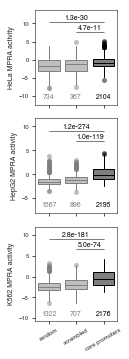

In [44]:
order = ["RANDOM", "SCRAMBLED", "WILDTYPE"]
palette = {"RANDOM": "gray", "SCRAMBLED": "gray", "WILDTYPE": "black"}

f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(1.78, 5))
neg_control_plot(pool1_hela_elem_norm, order, palette, fontsize, "HeLa", axarr[0], None, "HeLa MPRA activity", 
                 False, False, False, None)
neg_control_plot(pool1_hepg2_elem_norm, order, palette, fontsize, "HepG2", axarr[1], None, "HepG2 MPRA activity", 
                 False, False, False, None)
neg_control_plot(pool1_k562_elem_norm, order, palette, fontsize, "K562", axarr[2], None, "K562 MPRA activity", 
                 False, False, False, None)
plt.tight_layout()
f.savefig("Fig_1C_S4A.pdf", bbox_inches="tight", dpi="figure")

y_1: 8.5, y_2: 6
rand_pval: 1.32497538616e-30, scram_pval: 4.72968645318e-11
y_1: 8.5, y_2: 6
rand_pval: 1.17132621074e-274, scram_pval: 1.00414951338e-119
y_1: 8.5, y_2: 6
rand_pval: 2.75667614727e-181, scram_pval: 5.01255506218e-74


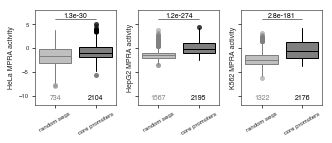

In [45]:
talk_order = ["RANDOM", "WILDTYPE"]
talk_palette = {"RANDOM": "gray", "WILDTYPE": "black"}

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(4.7, 2))
neg_control_plot(pool1_hela_elem_norm, talk_order, talk_palette, fontsize, "HeLa", axarr[0], None, "HeLa MPRA activity", 
                 True, False, False, None)
neg_control_plot(pool1_hepg2_elem_norm, talk_order, talk_palette, fontsize, "HepG2", axarr[1], None, "HepG2 MPRA activity", 
                 True, False, False, None)
neg_control_plot(pool1_k562_elem_norm, talk_order, talk_palette, fontsize, "K562", axarr[2], None, "K562 MPRA activity", 
                 True, False, False, None)
plt.tight_layout()
#plt.ylim((-10, 11))
f.savefig("neg_ctrl_boxplots.for_talk.pdf", bbox_inches="tight", dpi="figure")

### pool 2

y_1: 9.42783493857, y_2: 7.23987496313
rand_pval: 5.11647933556e-17, scram_pval: 7.90973564244e-10
y_1: 8.26308778415, y_2: 5.97168986664
rand_pval: 2.58113913894e-06, scram_pval: 0.00122751191285


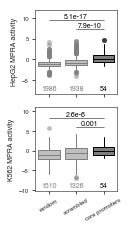

In [46]:
f, axarr = plt.subplots(2, sharex=True, sharey=False, figsize=(1.78, 3.2))
neg_control_plot(pool2_hepg2_elem_norm, order, palette, fontsize, "HepG2", axarr[0], None, "HepG2 MPRA activity", 
                 False, False, False, None)
neg_control_plot(pool2_k562_elem_norm, order, palette, fontsize, "K562", axarr[1], None, "K562 MPRA activity", 
                 False, False, False, None)
plt.tight_layout()
f.savefig("Fig_S8.pdf", bbox_inches="tight", dpi="figure")

## 5. boxplots: across TSS classes

In [47]:
def promtype_plot(df, order, palette, labels, fontsize, cell_type, ax, figsize, ylabel, sharey, title, save, plotname):
    
    df = df[df["better_type"].isin(["WILDTYPE", "SCRAMBLED", "RANDOM"])]
    
    if ax == None:
        plt.figure(figsize=figsize)
        ax = sns.boxplot(data=df, x="PromType2", y="overall_mean", order=order, palette=palette, linewidth=1,
                         saturation=1, flierprops=dict(marker='o', markersize=5))
    else:
        sns.boxplot(ax=ax, data=df, x="PromType2", y="overall_mean", order=order, palette=palette, linewidth=1,
                    saturation=1, flierprops=dict(marker='o', markersize=5))
    
    if "random" in order:
        ax.set_xticklabels(["random", "eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
    elif "scrambled" in order:
        ax.set_xticklabels(["scrambled", "eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
    else:
        ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)
    mimic_r_boxplot(ax)
    
    # calc p-vals b/w dists
    if "random" in order:
        rand_dist = np.asarray(df[df["PromType2"] == "random"]["overall_mean"])
        rand_dist = rand_dist[~np.isnan(rand_dist)]
    if "scrambled" in order:
        scram_dist = np.asarray(df[df["PromType2"] == "scrambled"]["overall_mean"])
        scram_dist = scram_dist[~np.isnan(scram_dist)]
        
    enh_dist = np.asarray(df[df["PromType2"] == "Enhancer"]["overall_mean"])
    enh_dist = enh_dist[~np.isnan(enh_dist)]
    
    int_dist = np.asarray(df[df["PromType2"] == "intergenic"]["overall_mean"])
    int_dist = int_dist[~np.isnan(int_dist)]
    
    div_lnc_dist = np.asarray(df[df["PromType2"] == "div_lnc"]["overall_mean"])
    div_lnc_dist = div_lnc_dist[~np.isnan(div_lnc_dist)]
    
    pc_dist = np.asarray(df[df["PromType2"] == "protein_coding"]["overall_mean"])
    pc_dist = pc_dist[~np.isnan(pc_dist)]
    
    div_pc_dist = np.asarray(df[df["PromType2"] == "div_pc"]["overall_mean"])
    div_pc_dist = div_pc_dist[~np.isnan(div_pc_dist)]
    
    if "random" in order:
        # random pvals
        enh_n_u, enh_n_pval = stats.mannwhitneyu(rand_dist, enh_dist, alternative="two-sided", use_continuity=False)
        int_n_u, int_n_pval = stats.mannwhitneyu(rand_dist, int_dist, alternative="two-sided", use_continuity=False)
        div_lnc_n_u, div_lnc_n_pval = stats.mannwhitneyu(rand_dist, div_lnc_dist, alternative="two-sided", use_continuity=False)
        pc_n_u, pc_n_pval = stats.mannwhitneyu(rand_dist, pc_dist, alternative="two-sided", use_continuity=False)
        div_pc_n_u, div_pc_n_pval = stats.mannwhitneyu(rand_dist, div_pc_dist, alternative="two-sided", use_continuity=False)
    
    if "scrambled" in order:
        # scrambled pvals
        enh_n_u, enh_n_pval = stats.mannwhitneyu(scram_dist, enh_dist, alternative="two-sided", use_continuity=False)
        int_n_u, int_n_pval = stats.mannwhitneyu(scram_dist, int_dist, alternative="two-sided", use_continuity=False)
        div_lnc_n_u, div_lnc_n_pval = stats.mannwhitneyu(scram_dist, div_lnc_dist, alternative="two-sided", use_continuity=False)
        pc_n_u, pc_n_pval = stats.mannwhitneyu(scram_dist, pc_dist, alternative="two-sided", use_continuity=False)
        div_pc_n_u, div_pc_n_pval = stats.mannwhitneyu(scram_dist, div_pc_dist, alternative="two-sided", use_continuity=False)
    
    lnc_u, lnc_pval = stats.mannwhitneyu(int_dist, div_lnc_dist, alternative="two-sided", use_continuity=False)
    pc_u, pc_pval = stats.mannwhitneyu(pc_dist, div_pc_dist, alternative="two-sided", use_continuity=False)

    if "random" in order:
        all_dists = list(rand_dist) + list(enh_dist) + list(int_dist) + list(div_lnc_dist) + list(pc_dist) + list(div_pc_dist)
    if "scrambled" in order:
        all_dists = list(scram_dist) + list(enh_dist) + list(int_dist) + list(div_lnc_dist) + list(pc_dist) + list(div_pc_dist)
    else:
        all_dists = list(enh_dist) + list(int_dist) + list(div_lnc_dist) + list(pc_dist) + list(div_pc_dist)
        
    if sharey:
        ax.set_ylim((-20, 10))
        #ax.yaxis.set_ticks(np.arange(-15, 11, 5))
        y_2 = 6
        y_1 = 6
    else:
        ax.set_ylim((np.min(all_dists)-5, np.max(all_dists)+12))
        #ax.yaxis.set_ticks(np.arange(round(np.min(all_dists)-2), round(np.max(all_dists)+3.5), 5))
        y_2 = np.max(pc_dist)+2
        y_1 = np.max(pc_dist)+2
    
        
    # statistical annotation for divergents
    if "random" in order or "scrambled" in order:
        annotate_pval(ax, 2, 3, y_1, 0, 0, lnc_pval, fontsize, True,
                      palette["intergenic"], palette["div_lnc"])
        annotate_pval(ax, 4, 5, y_2, 0, 0, pc_pval, fontsize, True,
                      palette["protein_coding"], palette["div_pc"])
    else:
        annotate_pval(ax, 1, 2, y_1, 0, 0, lnc_pval, fontsize, True,
                      palette["intergenic"], palette["div_lnc"])
        annotate_pval(ax, 3, 4, y_2, 0, 0, pc_pval, fontsize, True,
                      palette["protein_coding"], palette["div_pc"])
    
    # statistical annotation for nulls
    if "random" in order or "scrambled" in order:
        y_1 = np.max(all_dists)+2
        annotate_pval(ax, 0, 1, y_1, 0, 0, enh_n_pval, fontsize, True, 
                      palette["random"], palette["Enhancer"])
        for i, color, p in zip([2,3,4,5],[palette["intergenic"], palette["div_lnc"], palette["protein_coding"], palette["div_pc"]], [int_n_pval, div_lnc_n_pval, pc_n_pval, div_pc_n_pval]):
            # find y_1 by going up from y_2 in axes fraction coords
            x_ax, y_ax = axis_data_coords_sys_transform(ax, 0, y_1, inverse=True)
            y_1_ax = y_ax + 0.08
            x_data, y_1 = axis_data_coords_sys_transform(ax, x_ax, y_1_ax, inverse=False)

            annotate_pval(ax, 0, i, y_1, 0, 0, p, fontsize, True,
                          palette["random"], color)
        
    # reset axlim
    if not sharey:
        x_ax, y_ax = axis_data_coords_sys_transform(ax, 0, y_1, inverse=True)
        x_d, ylim_d = axis_data_coords_sys_transform(ax, 0, y_ax + 0.08, inverse=False)
        ax.set_ylim((np.min(all_dists)-5, ylim_d))
    
    # annotate group #s
    x_ax_0, y_ax = axis_data_coords_sys_transform(ax, 0, 0, inverse=True)
    x_ax_1, y_ax = axis_data_coords_sys_transform(ax, 1, 0, inverse=True)
    x_ax_2, y_ax = axis_data_coords_sys_transform(ax, 2, 0, inverse=True)
    x_ax_3, y_ax = axis_data_coords_sys_transform(ax, 3, 0, inverse=True)
    x_ax_4, y_ax = axis_data_coords_sys_transform(ax, 4, 0, inverse=True)
    x_ax_5, y_ax = axis_data_coords_sys_transform(ax, 5, 0, inverse=True)
    
    
    if "random" in order:
        ax.annotate(str(len(rand_dist)), xy=(x_ax_0, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["random"], size=fontsize)
    if "scrambled" in order:
        ax.annotate(str(len(scram_dist)), xy=(x_ax_0, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                    textcoords="offset pixels", ha='center', va='bottom', 
                    color=palette["scrambled"], size=fontsize)
        
    if "random" not in order and "scrambled" not in order:
        diff = 1./len(order)
    else:
        diff = 0
    ax.annotate(str(len(enh_dist)), xy=(x_ax_1-diff, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=palette["Enhancer"], size=fontsize)
    ax.annotate(str(len(int_dist)), xy=(x_ax_2-diff, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=palette["intergenic"], size=fontsize)
    ax.annotate(str(len(div_lnc_dist)), xy=(x_ax_3-diff, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=palette["div_lnc"], size=fontsize)
    ax.annotate(str(len(pc_dist)), xy=(x_ax_4-diff, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=palette["protein_coding"], size=fontsize)
    ax.annotate(str(len(div_pc_dist)), xy=(x_ax_5-diff, 0.02), xycoords="axes fraction", xytext=(0, 0), 
                textcoords="offset pixels", ha='center', va='bottom', 
                color=palette["div_pc"], size=fontsize)
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    if title:
        ax.set_title("%s" % (cell_type))
    if save:
        plt.savefig("%s/%s.pdf" % (figs_dir, plotname), dpi="figure", bbox_inches="tight")

In [48]:
palette = {"random": "gray", "scrambled": "gray", "Enhancer": sns.color_palette("deep")[1], 
           "intergenic": sns.color_palette("deep")[2], "protein_coding": sns.color_palette("deep")[5], 
           "div_lnc": sns.color_palette("deep")[3], "div_pc": sns.color_palette("deep")[0]}

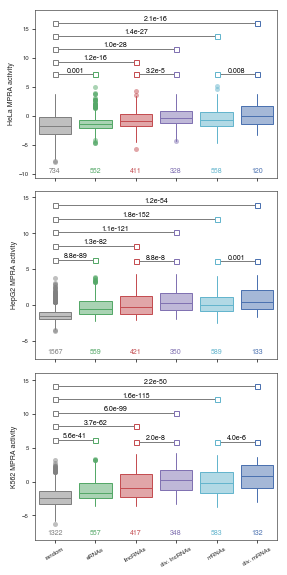

In [49]:
# random
order = ["random", "Enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
labels = ["random", "eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"]

f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(4, 8))
promtype_plot(pool1_hela_df, order, palette, labels, fontsize, "HeLa", axarr[0], None, 
              "HeLa MPRA activity", False, False, False, None)
promtype_plot(pool1_hepg2_df, order, palette, labels, fontsize, "HepG2", axarr[1], None, 
              "HepG2 MPRA activity", False, False, False, None)
promtype_plot(pool1_k562_df, order, palette, labels, fontsize, "K562", axarr[2], None, 
              "K562 MPRA activity", False, False, False, None)
plt.tight_layout()
f.savefig("Fig1_All_Biotypes_v_Random.pdf", bbox_inches="tight", dpi="figure")

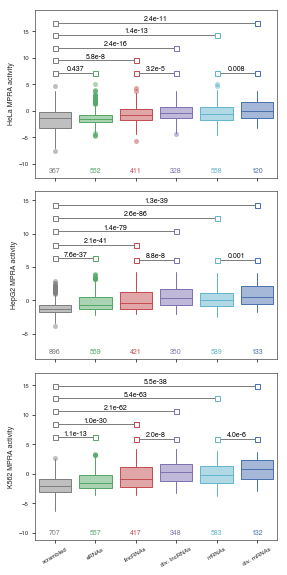

In [50]:
# scrambled
order = ["scrambled", "Enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
labels = ["scrambled", "eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"]

f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(4, 8))
promtype_plot(pool1_hela_df, order, palette, labels, fontsize, "HeLa", axarr[0], None, 
              "HeLa MPRA activity", False, False, False, None)
promtype_plot(pool1_hepg2_df, order, palette, labels, fontsize, "HepG2", axarr[1], None, 
              "HepG2 MPRA activity", False, False, False, None)
promtype_plot(pool1_k562_df, order, palette, labels, fontsize, "K562", axarr[2], None, 
              "K562 MPRA activity", False, False, False, None)
plt.tight_layout()
f.savefig("Fig1_All_Biotypes_v_Scrambled.pdf", bbox_inches="tight", dpi="figure")

## expression-match

In [51]:
def fix_enh_cage_id(row):
    if row.PromType2 == "Enhancer":
        if not pd.isnull(row.enhancer_id_x):
            return row.enhancer_id_x
        elif not pd.isnull(row.enhancer_id_y):
            return row.enhancer_id_y
        else:
            return np.nan
    else:
        return row.cage_id

In [52]:
sel_map["cage_id"] = sel_map["TSS_id"]
sel_map = sel_map.merge(enh_id_map[["TSS_id_Pos", "enhancer_id"]],
                        left_on="TSS_id", right_on="TSS_id_Pos", how="left")
sel_map = sel_map.merge(enh_id_map[["TSS_id_Neg", "enhancer_id"]],
                        left_on="TSS_id", right_on="TSS_id_Neg", how="left")
sel_map["cage_id"] = sel_map.apply(fix_enh_cage_id, axis=1)
sel_map.drop(["TSS_id_Pos", "enhancer_id_x", "TSS_id_Neg", "enhancer_id_y"], axis=1, inplace=True)
sel_map_expr = sel_map.merge(cage_exp, on="cage_id", how="left")
sel_map_expr.sample(5)

,oligo_reg,TSS_id,selected,PromType2,cage_id,av_exp,tissue_sp_all,tissue_sp_3,n_expr,tss_type
478,"chr1:110009143..110009257,+","chr1:110009215..110009235,+",mRNA.gwas,protein_coding,"chr1:110009215..110009235,+",1.611708,0.986765,0.666667,174.0,moderate
2462,"chrX:154029191..154029305,-","chrX:154029225..154029226,-",eRNA.gwas,Enhancer,chrX:154028913-154029459,0.239834,0.993855,NaN,69.0,moderate
2573,"chr17:37024702..37024816,+","chr17:37024781..37024782,+",eRNA.random,Enhancer,chr17:37024501-37024874,0.127245,0.983834,0.627823,143.0,moderate
21,"chr11:506733..506847,-","chr11:506739..506814,-",mRNA.gwas,protein_coding,"chr11:506739..506814,-",31.695853,0.737808,0.020722,550.0,ubiquitous
1002,"chr9:132253021..132253135,+","chr9:132253078..132253126,+",lncRNA,intergenic,"chr9:132253078..132253126,+",0.879865,0.979622,0.647828,283.0,moderate


In [53]:
sel_map_expr["log_av_exp"] = np.log10(sel_map_expr["av_exp"])
sel_map_expr.selected.unique()

array(['mRNA.random', 'mRNA.gwas', 'mRNA.expmatch', 'mRNA.bidirec70-160',
       'lncRNA', 'control.eQTLprom', 'control.prom', 'lncRNA.gwas',
       'eRNA.random', 'eRNA.expmatch', 'eRNA.gwas', 'eRNA.highlyexp',
       'control.eQTL', 'control.enhancer'], dtype=object)

In [54]:
rand_sel_types = ["lncRNA", "eRNA.random", "mRNA.random", "mRNA.bidirec70-160"]

In [55]:
rand_sel_ids = sel_map_expr[sel_map_expr["selected"].isin(rand_sel_types)]

In [56]:
rand_sel_ids.PromType2.value_counts()

div_lnc           526
intergenic        487
Enhancer          218
protein_coding    204
antisense         189
div_pc            187
Name: PromType2, dtype: int64

In [57]:
def get_matching_pairs(df_1, df_2, col, scaler=True):

    x_1 = np.asarray(df_1[col])
    x_2 = np.asarray(df_2[col])
    x_1 = np.reshape(x_1, (len(df_1), 1))
    x_2 = np.reshape(x_2, (len(df_2), 1))

    if scaler == True:
        scaler = StandardScaler()
    if scaler:
        scaler.fit(x_2)
        x_2 = scaler.transform(x_2)
        x_1 = scaler.transform(x_1)
        
    nbrs = NearestNeighbors(n_neighbors=1).fit(x_2)
    distances, indices = nbrs.kneighbors(x_1)
    indices = indices.reshape(indices.shape[0])
    matched = df_2.ix[indices]
    return matched

In [58]:
# match every biotype to the selected lncRNAs
promtypes = ["Enhancer", "protein_coding", "div_lnc", "div_pc"]
lncRNAs = sel_map_expr[(sel_map_expr["selected"] == "lncRNA") & 
                       (sel_map_expr["PromType2"] == "intergenic")].drop_duplicates()

print("total selected lncRNAs: %s" % len(lncRNAs))
print("min lncRNA expression: %s" % np.min(lncRNAs["av_exp"]))
print("max lncRNA expression: %s" % np.max(lncRNAs["av_exp"]))

all_matched = lncRNAs.copy()
for promtype in promtypes:
    sub_df = sel_map_expr[sel_map_expr["PromType2"] == promtype].drop_duplicates().reset_index()
    matched = get_matching_pairs(lncRNAs, sub_df, col="log_av_exp")
    print("%s (total=%s, matched=%s)" % (promtype, len(sub_df), len(matched)))
    all_matched = all_matched.append(matched)
all_matched = all_matched.drop_duplicates()

total selected lncRNAs: 487
min lncRNA expression: 0.0226472457484
max lncRNA expression: 9758.48618928
Enhancer (total=722, matched=487)
protein_coding (total=719, matched=487)
div_lnc (total=526, matched=487)
div_pc (total=232, matched=487)


In [59]:
all_matched.PromType2.value_counts()

intergenic        487
protein_coding    247
div_lnc           213
Enhancer          167
div_pc             87
Name: PromType2, dtype: int64

In [60]:
def distplot_biotypes(df, figsize, palette, label_dict, ylim, xlabel, save, plotname):
    fig = plt.figure(figsize=figsize)
    df = df.drop_duplicates()
    
    for i, promtype in enumerate(["Enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]):
        sub = df[df["PromType2"] == promtype]
        color = palette[promtype]
        label = label_dict[promtype]
        if i == 0:
            ax = sns.kdeplot(sub["log_av_exp"], cumulative=True, color=color, 
                              label="%s (n=%s)" % (label, len(sub)))
        else:
            sns.kdeplot(sub["log_av_exp"], cumulative=True, color=color, 
                         label="%s (n=%s)" % (label, len(sub)), ax=ax)
    
    plt.ylim(ylim)
    plt.xlabel(xlabel)
    plt.ylabel("cumulative density")
    if save:
        fig.savefig("%s.pdf" % plotname, dpi="figure", bbox_inches="tight")

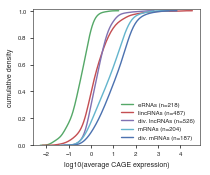

In [61]:
label_dict = {"Enhancer": "eRNAs", "intergenic": "lincRNAs", "div_lnc": "div. lncRNAs", "protein_coding": "mRNAs",
              "div_pc": "div. mRNAs"}
distplot_biotypes(rand_sel_ids, (3, 2.5), palette, label_dict, (0, 1.01), "log10(average CAGE expression)", True, "Random_Sel_Expr_Dist")

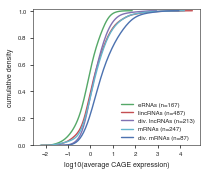

In [62]:
distplot_biotypes(all_matched, (3, 2.5), palette, label_dict, (0, 1.01), "log10(average CAGE expression)", True, "ExpMatch_Sel_Expr_Dist")

In [63]:
pool1_hela_rand = pool1_hela_df[pool1_hela_df["oligo_reg"].isin(rand_sel_ids["oligo_reg"])]
pool1_hepg2_rand = pool1_hepg2_df[pool1_hepg2_df["oligo_reg"].isin(rand_sel_ids["oligo_reg"])]
pool1_k562_rand = pool1_k562_df[pool1_k562_df["oligo_reg"].isin(rand_sel_ids["oligo_reg"])]

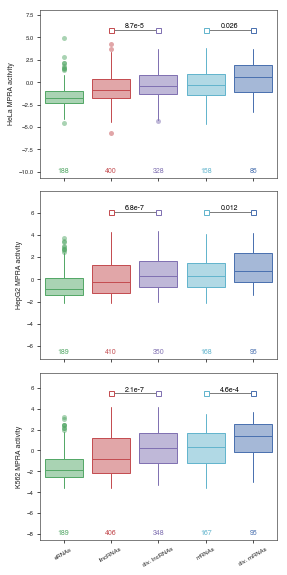

In [64]:
order = ["Enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
labels = ["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"]

f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(4, 8))
promtype_plot(pool1_hela_rand, order, palette, labels, fontsize, "HeLa", axarr[0], None, 
              "HeLa MPRA activity", False, False, False, None)
promtype_plot(pool1_hepg2_rand, order, palette, labels, fontsize, "HepG2", axarr[1], None, 
              "HepG2 MPRA activity", False, False, False, None)
promtype_plot(pool1_k562_rand, order, palette, labels, fontsize, "K562", axarr[2], None, 
              "K562 MPRA activity", False, False, False, None)
plt.tight_layout()
f.savefig("Fig1_All_Biotypes_Random_Sel.pdf", bbox_inches="tight", dpi="figure")

In [65]:
pool1_hela_exp = pool1_hela_df[pool1_hela_df["oligo_reg"].isin(all_matched["oligo_reg"])]
pool1_hepg2_exp = pool1_hepg2_df[pool1_hepg2_df["oligo_reg"].isin(all_matched["oligo_reg"])]
pool1_k562_exp = pool1_k562_df[pool1_k562_df["oligo_reg"].isin(all_matched["oligo_reg"])]

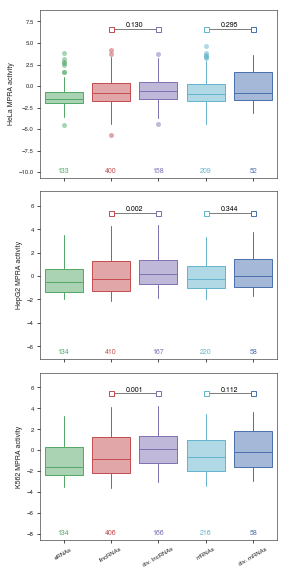

In [66]:
f, axarr = plt.subplots(3, sharex=True, sharey=False, figsize=(4, 8))
promtype_plot(pool1_hela_exp, order, palette, labels, 
              fontsize, "HeLa", axarr[0], None, "HeLa MPRA activity", False, False, False, None)
promtype_plot(pool1_hepg2_exp, order, palette, labels, 
              fontsize, "HepG2", axarr[1], None, "HepG2 MPRA activity", False, False, False, None)
promtype_plot(pool1_k562_exp, order, palette, labels, 
              fontsize, "K562", axarr[2], None, "K562 MPRA activity", False, False, False, None)
plt.tight_layout()
f.savefig("Fig1_All_Biotypes_ExpMatch_Sel.pdf", bbox_inches="tight", dpi="figure")

the rest of the analysis only uses pool 1 (the TSS pool), as it looks at patterns in expression differences between TSS classes

## 6. barplots: find % of sequences active across cell types

In [67]:
pool1_hela_df["cell"] = "HeLa"
pool1_hepg2_df["cell"] = "HepG2"
pool1_k562_df["cell"] = "K562"

all_df = pool1_hela_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]].append(pool1_hepg2_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]]).append(pool1_k562_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]])

In [68]:
df = all_df[all_df["better_type"] == "WILDTYPE"]
activ_grp = df.groupby("unique_id")["cell", "combined_class"].agg(lambda x: list(x)).reset_index()
activ_grp = activ_grp.merge(annot, left_on="unique_id", right_on="seqID", how="left").drop("seqID", axis=1)
activ_grp = activ_grp[(activ_grp["PromType2"].isin(TSS_CLASS_ORDER)) & 
                      ~(activ_grp["unique_id"].str.contains("SCRAMBLED"))]
activ_grp.sample(10)

,unique_id,cell,combined_class,PromType2
369,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr6...,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",Enhancer
219,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,"[HeLa, HepG2, K562]","[not sig, not sig, sig active]",Enhancer
1365,WILDTYPE__Enhancer.flip.sense__chr6:14735225.....,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer
407,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr1...,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",div_lnc
283,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",Enhancer
303,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",Enhancer
210,WILDTYPE_BUT_HAS_SNP__Enhancer.flip.sense__chr...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer
359,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr6...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer
628,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr7:54...,"[HeLa, HepG2, K562]","[sig active, sig active, sig active]",div_pc
1742,WILDTYPE__Lincrna.noflip.NA__chr19:4769065..47...,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",intergenic


In [69]:
activ_grp["active_in_only_one"] = activ_grp.apply(active_in_only_one, axis=1)
activ_grp["active_in_only_two"] = activ_grp.apply(active_in_only_two, axis=1)
activ_grp["active_in_only_three"] = activ_grp.apply(active_in_only_three, axis=1)
activ_grp.sample(5)

,unique_id,cell,combined_class,PromType2,active_in_only_one,active_in_only_two,active_in_only_three
1069,WILDTYPE__Antisense.flip.sense__chr6:30294598....,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",div_lnc,True,False,False
1075,WILDTYPE__Antisense.flip.sense__chr7:29603272....,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",div_lnc,False,False,False
2185,WILDTYPE__mrna.noflip.NA__chr6:168227511..1682...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",div_pc,False,False,False
2148,WILDTYPE__mrna.noflip.NA__chr2:220071565..2200...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",protein_coding,False,False,False
1779,WILDTYPE__Lincrna.noflip.NA__chr21:25800972..2...,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",intergenic,True,False,False


In [70]:
for PromType2 in TSS_CLASS_ORDER:
    df = activ_grp[activ_grp["PromType2"] == PromType2]
    active_in_1 = len(df[df["active_in_only_one"]])
    active_in_3 = len(df[df["active_in_only_three"]])
    print("%s | active in 1: %s, active in 3: %s" % (PromType2, active_in_1, active_in_3))

Enhancer | active in 1: 146, active in 3: 24
intergenic | active in 1: 78, active in 3: 69
div_lnc | active in 1: 60, active in 3: 77
protein_coding | active in 1: 97, active in 3: 105
div_pc | active in 1: 10, active in 3: 41


In [71]:
activ_counts_1 = activ_grp.groupby(["PromType2", "active_in_only_one"])["unique_id"].agg("count").reset_index()
activ_pcts_1 = activ_counts_1.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_1["percent"] = activ_pcts_1

activ_counts_2 = activ_grp.groupby(["PromType2", "active_in_only_two"])["unique_id"].agg("count").reset_index()
activ_pcts_2 = activ_counts_2.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_2["percent"] = activ_pcts_2

activ_counts_3 = activ_grp.groupby(["PromType2", "active_in_only_three"])["unique_id"].agg("count").reset_index()
activ_pcts_3 = activ_counts_3.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_3["percent"] = activ_pcts_3

activ_counts_1 = activ_counts_1[activ_counts_1["active_in_only_one"]]
activ_counts_2 = activ_counts_2[activ_counts_2["active_in_only_two"]]
activ_counts_3 = activ_counts_3[activ_counts_3["active_in_only_three"]]

activ_counts = activ_counts_1.merge(activ_counts_2, on="PromType2").merge(activ_counts_3, on="PromType2")
activ_counts.drop(["active_in_only_one", "unique_id_x", "active_in_only_two", "unique_id_y", 
                   "active_in_only_three", "unique_id"],
                  axis=1, inplace=True)
activ_counts.columns = ["PromType2", "active_in_only_one", "active_in_only_two", "active_in_only_three"]
activ_counts = pd.melt(activ_counts, id_vars="PromType2")
activ_counts.head()

,PromType2,variable,value
0,Enhancer,active_in_only_one,25.886525
1,div_lnc,active_in_only_one,16.997167
2,div_pc,active_in_only_one,7.299270
3,intergenic,active_in_only_one,18.352941
4,protein_coding,active_in_only_one,16.193656


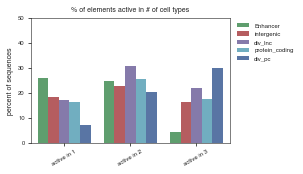

In [72]:
df = activ_counts[activ_counts["PromType2"] != "antisense"]
df["PromType2"] = pd.Categorical(df["PromType2"], TSS_CLASS_ORDER)
df.sort_values(by="PromType2")

plt.figure(figsize=(3.56, 2.3))
ax = sns.barplot(data=df, x="variable", y="value", hue="PromType2", ci=None, palette=TSS_CLASS_PALETTE)
ax.set_xticklabels(["active in 1", "active in 2", "active in 3"], rotation=30)

plt.legend(bbox_to_anchor=(1.35, 1))
plt.ylim((0, 50))
plt.ylabel("percent of sequences", size=fontsize)
plt.xlabel("")
plt.title("% of elements active in # of cell types")

In [73]:
colors = []
for c in TSS_CLASS_ORDER:
    colors.append(TSS_CLASS_PALETTE[c])
colors

[(0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]

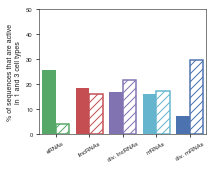

In [74]:
# better plot showing tissue sp
df = activ_counts[activ_counts["PromType2"] != "antisense"]
df["PromType2"] = pd.Categorical(df["PromType2"], TSS_CLASS_ORDER)
df.sort_values(by="PromType2")

plt.figure(figsize=(3,2.3))
ax = sns.barplot(data=df[df["variable"]!="active_in_only_two"], x="PromType2", y="value", 
                 ci=None, hue="variable", linewidth=1.5)
ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)

colors = colors*2
for i, p in enumerate(ax.patches):
    if i < 5:
        p.set_facecolor(colors[i])
    else:
        p.set_facecolor("white")
        p.set_edgecolor(colors[i])
        p.set_alpha(1)
        p.set_hatch("///")

ax.legend().set_visible(False)
plt.ylim((0, 50))
plt.ylabel("% of sequences that are active\nin 1 and 3 cell types", fontsize=fontsize)
plt.xlabel("")
plt.savefig("Fig_1F.pdf", bbox_inches="tight", dpi="figure")

## 7. kdeplot: compare to CAGE

In [75]:
hepg2_activ = pool1_hepg2_df[["unique_id", "element", "better_type", "overall_mean", "PromType2"]]
hela_activ = pool1_hela_df[["unique_id", "element", "better_type", "overall_mean"]]
k562_activ = pool1_k562_df[["unique_id", "element", "better_type", "overall_mean"]]

all_activ = hepg2_activ.merge(hela_activ, on=["unique_id", "element", "better_type"], how="left").merge(k562_activ, on=["unique_id", "element", "better_type"], how="left")
all_activ.columns = ["unique_id", "element", "better_type", "HepG2", "PromType2", "HeLa", "K562"]
all_activ = all_activ[["unique_id", "element", "better_type", "PromType2", "HepG2", "HeLa", "K562"]]
all_activ = all_activ[(all_activ["PromType2"].isin(TSS_CLASS_ORDER)) & 
                      ~(all_activ["unique_id"].str.contains("SCRAMBLED")) &
                      (all_activ["better_type"] == "WILDTYPE")]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562
6502,WILDTYPE__Enhancer.noflip.NA__chr5:71643905..7...,AAATTTCTCATGTTGCAATATAAGCCTATGTCATCTTCCTCGGGGA...,WILDTYPE,Enhancer,-1.870859,-2.643735,-1.806957
6435,WILDTYPE__Enhancer.noflip.NA__chr1:956631..956...,ATTTTCCCGACTTCCTCCCCGCTGCTCCTGGGTGTGGCTGGGGTGG...,WILDTYPE,Enhancer,0.439397,-2.122787,-0.534297
3229,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,AAACGGGCAGGGAGCATTCTAAATGGTGGGGGGGGGCGGTGGAGGC...,WILDTYPE,intergenic,0.667184,-0.003025,-0.910316
3313,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,CGCAGCCGCAGTCCGCTGAACCCTCGGCCGAGTTCTGTGGCTGCTG...,WILDTYPE,intergenic,3.906137,2.648758,3.220700
3612,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr12...,GGCTCCTCTCAGGGCTCCTTCCCCTGCCCCCATTCCACCCCAGCCC...,WILDTYPE,intergenic,-1.184290,-2.414816,-2.571927


In [76]:
all_activ["combined_class"] = ""
all_activ = all_activ.merge(pool1_hela_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_HeLa")).merge(pool1_hepg2_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_HepG2")).merge(pool1_k562_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_K562"))
all_activ.drop("combined_class", axis=1, inplace=True)
all_activ.head()

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GGTGGGCCCCCTCCCCCTTCTTCCGGCGGGCCTCCTCCCTCCCCTT...,WILDTYPE,intergenic,2.688943,-0.470427,1.981653,sig active,sig active,sig active
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GACTAAATAAGGGAGGCTGCAGCGGCTGCGCGTGCGCCCAGAGGCG...,WILDTYPE,div_lnc,-0.701841,0.371693,0.166442,not sig,sig active,not sig
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AACTCGCCCTCCGGAAAGACGCGGGGGAATTCTGGGAGTGCGCGGC...,WILDTYPE,intergenic,1.704007,0.456156,1.976386,sig active,sig active,sig active
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,CACCAACCGCCCCACCGCACCCTGCGCCAGCCCTACGGCGCCCGCG...,WILDTYPE,intergenic,-0.022075,1.114820,-0.701002,not sig,sig active,not sig
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AGACCCACAGGAAATGACGACAGAAGGGCTGAGGTGGGGGGGCGGG...,WILDTYPE,div_lnc,3.759629,2.141635,3.237685,sig active,sig active,sig active


In [77]:
all_activ["oligo_reg"] = all_activ.unique_id.str.split("__", expand=True)[2]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,oligo_reg
803,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr2:219...,GCTCTTCCTGCTGGGGAGTCGCCTACGCCTACTTCCTGCCGGGAGG...,WILDTYPE,protein_coding,2.161270,1.374158,2.394072,sig active,sig active,sig active,"chr2:219134825..219134939,-"
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GGTGGGCCCCCTCCCCCTTCTTCCGGCGGGCCTCCTCCCTCCCCTT...,WILDTYPE,intergenic,2.688943,-0.470427,1.981653,sig active,sig active,sig active,"chr10:11936664..11936778,-"
1050,WILDTYPE__Antisense.noflip.NA__chr15:45571414....,GCGATTGGTCCCCGTTTTGGGCCTCCCAGGATTGACTGGCCCTTCC...,WILDTYPE,intergenic,2.468721,0.888469,2.697568,sig active,sig active,sig active,"chr15:45571414..45571528,-"
1968,WILDTYPE__mrna.noflip.NA__chr19:52391169..5239...,TGCATCATAAAGGGACGGCTGGTGCCGTATTCCGTGTCTCCGGAAA...,WILDTYPE,protein_coding,1.064616,-1.282087,0.229699,not sig,sig active,sig active,"chr19:52391169..52391283,-"
1683,WILDTYPE__Lincrna.noflip.NA__chr4:6675592..667...,GCTCCCGCCTCAGCGGTCCTGCGCGCGCACGCGCACTTGCACGCAC...,WILDTYPE,intergenic,1.100527,0.748677,1.808060,not sig,sig active,not sig,"chr4:6675592..6675706,-"


In [78]:
id_map = id_map[["oligo_reg", "gene_id", "K562_rep1", "K562_rep2", "K562_rep3", "HeLa_rep1", "HeLa_rep2", "HeLa_rep3", 
                 "HepG2_rep1", "HepG2_rep2", "HepG2_rep3"]]
all_activ = all_activ.merge(id_map, on="oligo_reg")
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,gene_id,K562_rep1,K562_rep2,K562_rep3,HeLa_rep1,HeLa_rep2,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3
138,WILDTYPE_BUT_HAS_SNP__Enhancer.flip.sense__chr...,GGGATTCCCCCGCCCGCCGCGCGCCCGCCCTCCGCCCCTCCCCGCC...,WILDTYPE,Enhancer,-0.386499,-1.571484,-0.100527,not sig,sig active,not sig,...,NaN,9.013083,5.347894,7.030407,2.228012,0.915983,0.865130,1.573830,1.972177,1.162633
906,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr8:116...,TGCGGAGCGGGAGGCCGGGGGCGGGGCTGCGGGGCTGCGGGGCGGG...,WILDTYPE,protein_coding,-0.190734,3.316970,0.440600,not sig,not sig,not sig,...,ENSG00000079459.8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.024181,0.329663,0.337018
1141,WILDTYPE__Antisense.noflip.NA__chr9:86323150.....,GTCACGGTTAGCGAAATTACTAGAAAGGGACCAGTGGGCCCTGCGG...,WILDTYPE,div_lnc,-0.178913,-1.906003,-0.760599,not sig,sig active,sig active,...,ENSG00000254473.1,0.676787,0.784250,0.839108,0.677294,0.803982,0.410577,1.102965,0.824159,0.741439
37,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GTGGCTGCGGAGTTGGCGGGTCGGCGCCTGCGCACTGGAGTCCCCC...,WILDTYPE,div_lnc,0.601312,0.232015,0.549801,not sig,sig active,sig active,...,ENSG00000227627.1,4.737509,4.509438,4.195540,1.354589,1.900322,1.560194,4.096725,3.379050,3.639791
160,WILDTYPE_BUT_HAS_SNP__Enhancer.flip.sense__chr...,CCGCGTTTGCAAGAAACCGAAACCCAGGCTCCGCCCCTTCGGCGCG...,WILDTYPE,Enhancer,0.606370,-1.061891,0.414885,not sig,sig active,sig active,...,NaN,0.219831,0.190996,0.326996,0.835504,0.915983,0.629186,0.299777,0.473322,0.516726


In [79]:
all_activ["K562_av"] = all_activ[["K562_rep1", "K562_rep2", "K562_rep3"]].mean(axis=1)
all_activ["HeLa_av"] = all_activ[["HeLa_rep1", "HeLa_rep2", "HeLa_rep3"]].mean(axis=1)
all_activ["HepG2_av"] = all_activ[["HepG2_rep1", "HepG2_rep2", "HepG2_rep3"]].mean(axis=1)

all_activ["K562_log_av"] = np.log10(all_activ["K562_av"]+1)
all_activ["HeLa_log_av"] = np.log10(all_activ["HeLa_av"]+1)
all_activ["HepG2_log_av"] = np.log10(all_activ["HepG2_av"]+1)

In [80]:
all_activ = all_activ[(~all_activ["unique_id"].str.contains("SNP_INDIV")) & 
                      (~all_activ["unique_id"].str.contains("SNP_PLUS_HAPLO")) & 
                      (~all_activ["unique_id"].str.contains("FLIPPED"))]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3,K562_av,HeLa_av,HepG2_av,K562_log_av,HeLa_log_av,HepG2_log_av
72,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,CAGCCCCTTTCTGGGCGGGGATCTGTCCTGGCCGGATGGGAGGAGG...,WILDTYPE,div_lnc,-0.134519,1.547166,-0.863830,not sig,sig active,sig active,...,0.082115,0.000000,0.000000,0.000000,0.055941,0.051735,0.000000,0.023639,0.021906,0.000000
1021,WILDTYPE__Antisense.noflip.NA__chr10:89102178....,GCCTCCGGTGGCTGCTGGGATACCGGAGGACTCGGGTCCCGGCTCG...,WILDTYPE,intergenic,0.189024,-1.435425,-0.609282,not sig,sig active,sig active,...,1.149616,1.575664,1.318654,0.808843,1.271583,1.484650,1.234387,0.356329,0.395265,0.349158
1727,WILDTYPE__Lincrna.noflip.NA__chr8:112039616..1...,ATTATTCTGTTCAAAAGAGGATTTGTTTGTGATATTCCTTTAAGAA...,WILDTYPE,intergenic,-1.511820,-1.123779,-2.965519,not sig,not sig,not sig,...,0.000000,0.000000,0.000000,0.000000,0.055941,0.000000,0.000000,0.023639,0.000000,0.000000
208,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,TTAGCTTACAGCCTCTGGTTCCTGTTGGGAAACTTAGGGCTTGCCA...,WILDTYPE,Enhancer,-1.546995,-3.489054,-3.309489,sig repressive,not sig,not sig,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1883,WILDTYPE__mrna.noflip.NA__chr10:26727261..2672...,GGCCTCTCAGTCTTTGGTGGAACCATCACTAGGCCCCAATCCCTTA...,WILDTYPE,protein_coding,-1.235971,-1.020696,-2.452495,not sig,not sig,not sig,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [81]:
# first scale mpra ranges to be positive
all_activ["hepg2_scaled"] = scale_range(all_activ["HepG2"], 0, 100)
all_activ["hela_scaled"] = scale_range(all_activ["HeLa"], 0, 100)
all_activ["k562_scaled"] = scale_range(all_activ["K562"], 0, 100)

In [82]:
cage_ts = calculate_tissue_specificity(all_activ[["HepG2_log_av", "K562_log_av", "HeLa_log_av"]])
all_activ["cage_activ"] = all_activ[["HepG2_log_av", "K562_log_av", "HeLa_log_av"]].mean(axis=1)
all_activ["cage_ts"] = cage_ts

mpra_ts = calculate_tissue_specificity(all_activ[["hepg2_scaled", "k562_scaled", "hela_scaled"]])
all_activ["mpra_activ"] = all_activ[["HepG2", "K562", "HeLa"]].mean(axis=1)
all_activ["mpra_ts"] = mpra_ts
all_activ.head()

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,K562_log_av,HeLa_log_av,HepG2_log_av,hepg2_scaled,hela_scaled,k562_scaled,cage_activ,cage_ts,mpra_activ,mpra_ts
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GGTGGGCCCCCTCCCCCTTCTTCCGGCGGGCCTCCTCCCTCCCCTT...,WILDTYPE,intergenic,2.688943,-0.470427,1.981653,sig active,sig active,sig active,...,2.347876,0.000000,0.011258,76.188273,47.913344,71.954421,0.786378,0.665068,1.400056,0.142230
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GACTAAATAAGGGAGGCTGCAGCGGCTGCGCGTGCGCCCAGAGGCG...,WILDTYPE,div_lnc,-0.701841,0.371693,0.166442,not sig,sig active,not sig,...,0.297111,0.391102,0.445079,26.698185,55.709983,48.891741,0.377764,0.151243,-0.054568,0.214384
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AACTCGCCCTCCGGAAAGACGCGGGGGAATTCTGGGAGTGCGCGGC...,WILDTYPE,intergenic,1.704007,0.456156,1.976386,sig active,sig active,sig active,...,1.190115,1.090864,1.495307,61.812671,56.491967,71.887500,1.258762,0.158191,1.378850,0.118103
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,CACCAACCGCCCCACCGCACCCTGCGCCAGCCCTACGGCGCCCGCG...,WILDTYPE,intergenic,-0.022075,1.114820,-0.701002,not sig,sig active,not sig,...,0.874093,1.092124,0.850473,36.619685,62.590112,37.870653,0.938897,0.140302,0.130581,0.269957
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AGACCCACAGGAAATGACGACAGAAGGGCTGAGGTGGGGGGGCGGG...,WILDTYPE,div_lnc,3.759629,2.141635,3.237685,sig active,sig active,sig active,...,0.489428,0.656810,0.248772,91.815440,72.096713,87.912612,0.465003,0.292028,3.046316,0.085757


In [83]:
cmap = sns.light_palette("darkslategray", as_cmap=True)

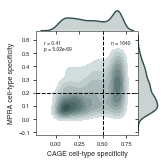

In [84]:
no_nan = all_activ[(~pd.isnull(all_activ["mpra_ts"])) & (~pd.isnull(all_activ["cage_ts"]))]
g = sns.jointplot(data=no_nan, x="cage_ts", y="mpra_ts", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, cmap=cmap, color="darkslategrey")
g.ax_joint.axhline(y=0.2, color="black", linewidth=1, linestyle="dashed")
g.ax_joint.axvline(x=0.5, color="black", linewidth=1, linestyle="dashed")
g.set_axis_labels("CAGE cell-type specificity", "MPRA cell-type specificity")
r, p = stats.spearmanr(no_nan["cage_ts"], no_nan["mpra_ts"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .75), xycoords=ax.transAxes, 
                    fontsize=5)
g.ax_joint.annotate("n = %s" % len(no_nan), xy=(.5, .8), xycoords=ax.transAxes, 
                    fontsize=5)
g.savefig("Fig_1E.pdf", bbox_inches="tight", dpi="figure")

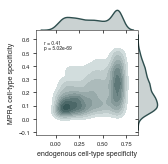

In [85]:
no_nan = all_activ[(~pd.isnull(all_activ["mpra_ts"])) & (~pd.isnull(all_activ["cage_ts"]))]
g = sns.jointplot(data=no_nan, x="cage_ts", y="mpra_ts", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, cmap=cmap, color="darkslategrey")
g.set_axis_labels("endogenous cell-type specificity", "MPRA cell-type specificity")
r, p = stats.spearmanr(no_nan["cage_ts"], no_nan["mpra_ts"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .75), xycoords=ax.transAxes, 
                    fontsize=5)
g.savefig("cage_mpra_corr.for_talk.pdf", bbox_inches="tight", dpi="figure")

In [86]:
def cage_v_mpra_ts(row):
    if row["cage_ts"] > 0.5 and row["mpra_ts"] > 0.2:
        return "ts in both"
    elif row["cage_ts"] > 0.5 and row["mpra_ts"] <= 0.2:
        return "ts in cage, not mpra"
    elif row["cage_ts"] <= 0.5 and row["mpra_ts"] > 0.2:
        return "ts in mpra, not cage"
    else:
        return "not ts in both"
    
no_nan["ts_status"] = no_nan.apply(cage_v_mpra_ts, axis=1)
no_nan.ts_status.value_counts()

not ts in both          692
ts in both              402
ts in mpra, not cage    310
ts in cage, not mpra    236
Name: ts_status, dtype: int64

In [87]:
tot = 692+402+310+236
upper_left = 310
upper_right = 402
lower_left = 692
lower_right = 236
print("upper left: %s" % (upper_left/tot))
print("upper right: %s" % (upper_right/tot))
print("lower left: %s" % (lower_left/tot))
print("lower right: %s" % (lower_right/tot))

upper left: 0.18902439024390244
upper right: 0.2451219512195122
lower left: 0.4219512195121951
lower right: 0.14390243902439023


In [88]:
(692+402)/(692+402+310+236)

0.6670731707317074

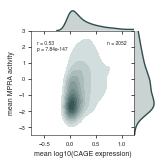

In [89]:
no_nan = all_activ[(~pd.isnull(all_activ["mpra_activ"])) & (~pd.isnull(all_activ["cage_activ"]))]
g = sns.jointplot(data=no_nan, x="cage_activ", y="mpra_activ", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, xlim=(-0.75, 1.25), ylim=(-3.5, 3), cmap=cmap, color="darkslategray")
g.set_axis_labels("mean log10(CAGE expression)", "mean MPRA activity")
r, p = stats.spearmanr(no_nan["cage_activ"], no_nan["mpra_activ"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.06, .75), xycoords=ax.transAxes, 
                    fontsize=5)
g.ax_joint.annotate("n = %s" % len(no_nan), xy=(.48, .8), xycoords=ax.transAxes, 
                    fontsize=5)
g.savefig("av_CAGE_v_av_MPRA.pdf", bbox_inches="tight", dpi="figure")

## 8. compare MPRA and CAGE to RNA-seq

In [90]:
rna_seq_exp = rna_seq_exp[["gene_id", "HepG2", "HeLa-S3", "K562"]]
rna_seq_exp.columns = ["gene_id", "HepG2_rna_seq", "HeLa_rna_seq", "K562_rna_seq"]
rna_seq_exp["HepG2_rna_seq_log"] = np.log10(rna_seq_exp["HepG2_rna_seq"]+1)
rna_seq_exp["HeLa_rna_seq_log"] = np.log10(rna_seq_exp["HeLa_rna_seq"]+1)
rna_seq_exp["K562_rna_seq_log"] = np.log10(rna_seq_exp["K562_rna_seq"]+1)
all_activ_rna_seq = all_activ.merge(rna_seq_exp, on="gene_id")
all_activ_rna_seq.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,cage_activ,cage_ts,mpra_activ,mpra_ts,HepG2_rna_seq,HeLa_rna_seq,K562_rna_seq,HepG2_rna_seq_log,HeLa_rna_seq_log,K562_rna_seq_log
187,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr8:...,GCCGGAAGGGGCGGGCTTTCCGCCTGCACCAGGCGCTTCCGCCACC...,WILDTYPE,intergenic,2.847033,1.572784,2.549828,sig active,sig active,sig active,...,0.087110,0.108894,2.323215,0.054819,13.211112,20.124026,34.253347,1.152628,1.324777,1.547200
219,WILDTYPE_BUT_HAS_SNP__Lincrna.noflip.NA__chr12...,ACGGTGTTCTGGGAGGAGTTACGCAGGCAGGGTTGTGGTTGCTGGC...,WILDTYPE,intergenic,-1.502372,-1.124685,1.933279,not sig,not sig,sig active,...,0.214150,0.377339,-0.231259,0.400943,3.300309,7.870443,33.811681,0.633500,0.947945,1.541725
1101,WILDTYPE__Lincrna.noflip.NA__chr20:58713468..5...,ACTCAGGCTCACCGGCAAACCTCTTCCGGTTCCGGTCAGGGTGCTG...,WILDTYPE,intergenic,3.072096,1.849748,2.624292,sig active,sig active,sig active,...,0.000000,NaN,2.515379,0.057257,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1025,WILDTYPE__Lincrna.noflip.NA__chr10:4720371..47...,AATCATTTTCAAATAAAGATAATAACTCAGTTGGTCTTGTAGTCCA...,WILDTYPE,intergenic,-1.134986,-1.419057,-0.459162,not sig,not sig,not sig,...,0.011272,0.666667,-1.004402,0.182201,0.607327,0.000000,0.000000,0.206104,0.000000,0.000000
407,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr4:40...,CTCCCCACCCGGCCGCCCACCCGCCCTCTCGCGGCGGGCTTCTGCG...,WILDTYPE,protein_coding,-0.227584,NaN,0.279668,not sig,not sig,not sig,...,0.864237,0.137844,0.026042,NaN,3.640908,2.440456,4.705645,0.666603,0.536616,0.756305


In [91]:
all_activ_rna_seq.PromType2.value_counts()

protein_coding    599
intergenic        425
div_lnc           353
div_pc            137
Name: PromType2, dtype: int64

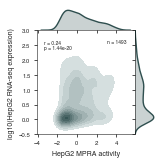

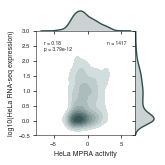

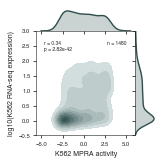

In [92]:
for cell in ["HepG2", "HeLa", "K562"]:
    mpra_col = cell
    seq_col = "%s_rna_seq_log" % cell
    
    no_nan = all_activ_rna_seq[(~pd.isnull(all_activ_rna_seq[mpra_col])) & (~pd.isnull(all_activ_rna_seq[seq_col]))]
    g = sns.jointplot(data=no_nan, x=mpra_col, y=seq_col, kind="kde", shade_lowest=False, size=2.3, space=0,
                      stat_func=None, cmap=cmap, color="darkslategray", ylim=(-0.5, 3))
    g.set_axis_labels("%s MPRA activity" % cell, "log10(%s RNA-seq expression)" % cell)
    r, p = stats.spearmanr(no_nan[mpra_col], no_nan[seq_col])
    g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .75), xycoords=ax.transAxes, 
                        fontsize=5)
    
    # add n-value
    g.ax_joint.annotate("n = %s" % len(no_nan), xy=(.475, .8), xycoords=ax.transAxes, 
                        fontsize=5)
    
    plt.show()
    g.savefig("%s_mpra_v_seq.pdf" % cell, bbox_inches="tight", dpi="figure")

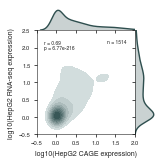

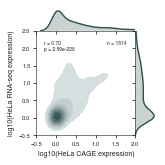

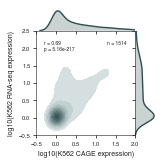

In [93]:
for cell in ["HepG2", "HeLa", "K562"]:
    cage_col = "%s_log_av" % cell
    seq_col = "%s_rna_seq_log" % cell
    
    no_nan = all_activ_rna_seq[(~pd.isnull(all_activ_rna_seq[cage_col])) & (~pd.isnull(all_activ_rna_seq[seq_col]))]
    g = sns.jointplot(data=no_nan, x=cage_col, y=seq_col, kind="kde", shade_lowest=False, size=2.3, space=0,
                      stat_func=None, cmap=cmap, color="darkslategray", ylim=(-0.5, 2.5), xlim=(-0.5, 2))
    g.set_axis_labels("log10(%s CAGE expression)" % cell, "log10(%s RNA-seq expression)" % cell)
    r, p = stats.spearmanr(no_nan[cage_col], no_nan[seq_col])
    g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .75), xycoords=ax.transAxes, 
                        fontsize=5)
    
    # add n-value
    g.ax_joint.annotate("n = %s" % len(no_nan), xy=(.475, .8), xycoords=ax.transAxes, 
                        fontsize=5)
    
    plt.show()
    g.savefig("%s_cage_v_seq.pdf" % cell, bbox_inches="tight", dpi="figure")

## 9. correlate activity with TSS conservation

In [94]:
len(all_activ)

2078

In [95]:
all_activ_phylop = all_activ.merge(pool1_phylop.drop(["chr", "start", "end", "score", "strand", "length"], axis=1), 
                                   on="unique_id")
print(len(all_activ_phylop))
all_activ_phylop.head()

2078


,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,24,25,26,27,28,29,30,31,32,33
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GGTGGGCCCCCTCCCCCTTCTTCCGGCGGGCCTCCTCCCTCCCCTT...,WILDTYPE,intergenic,2.688943,-0.470427,1.981653,sig active,sig active,sig active,...,0.50,0.31,0.50,0.50,-1.57,-0.49,-0.47,0.50,-0.59,-1.59
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GACTAAATAAGGGAGGCTGCAGCGGCTGCGCGTGCGCCCAGAGGCG...,WILDTYPE,div_lnc,-0.701841,0.371693,0.166442,not sig,sig active,not sig,...,-0.20,-0.28,-0.98,0.35,0.37,0.37,-0.01,1.45,-0.01,1.45
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AACTCGCCCTCCGGAAAGACGCGGGGGAATTCTGGGAGTGCGCGGC...,WILDTYPE,intergenic,1.704007,0.456156,1.976386,sig active,sig active,sig active,...,-0.22,-0.22,0.60,0.60,0.60,-0.20,-1.33,-0.34,-0.20,0.60
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,CACCAACCGCCCCACCGCACCCTGCGCCAGCCCTACGGCGCCCGCG...,WILDTYPE,intergenic,-0.022075,1.114820,-0.701002,not sig,sig active,not sig,...,-0.56,-0.52,-1.56,-0.84,-0.48,-0.19,-3.43,1.32,-1.57,0.01
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AGACCCACAGGAAATGACGACAGAAGGGCTGAGGTGGGGGGGCGGG...,WILDTYPE,div_lnc,3.759629,2.141635,3.237685,sig active,sig active,sig active,...,-1.40,-0.12,-2.10,-1.33,-1.32,-0.60,-0.52,-0.80,-1.19,0.42


In [96]:
all_activ.columns

Index(['unique_id', 'element', 'better_type', 'PromType2', 'HepG2', 'HeLa',
       'K562', 'combined_class_HeLa', 'combined_class_HepG2',
       'combined_class_K562', 'oligo_reg', 'gene_id', 'K562_rep1', 'K562_rep2',
       'K562_rep3', 'HeLa_rep1', 'HeLa_rep2', 'HeLa_rep3', 'HepG2_rep1',
       'HepG2_rep2', 'HepG2_rep3', 'K562_av', 'HeLa_av', 'HepG2_av',
       'K562_log_av', 'HeLa_log_av', 'HepG2_log_av', 'hepg2_scaled',
       'hela_scaled', 'k562_scaled', 'cage_activ', 'cage_ts', 'mpra_activ',
       'mpra_ts'],
      dtype='object')

In [97]:
res_dict = {}
df = all_activ_phylop
nuc_cols = list(np.arange(-80, 34, step=1))

for PromType2 in TSS_CLASS_ORDER:
    df_filt = df[df["PromType2"] == PromType2]
    prev_max = -4
    activ_res_dict = {}
    print(PromType2)
    for max_activ in [-2, -1, 0, 2, 4]:
        sub = df_filt[(df_filt["mpra_activ"] > prev_max) & (df_filt["mpra_activ"] <= max_activ)]
        n_seqs = len(sub)
        print("max activ: %s, n: %s" % (max_activ, n_seqs))
        nums = np.asarray(sub[nuc_cols])

        avg = np.nanmean(nums, axis=0)
        std = np.nanstd(nums, axis=0)

        y1 = avg - std
        y2 = avg + std

        activ_res_dict[max_activ] = {"n_seqs": n_seqs, "avg": avg, "y1": y1, "y2": y2}
        prev_max = max_activ
    res_dict[PromType2] = activ_res_dict

Enhancer
max activ: -2, n: 99
max activ: -1, n: 217
max activ: 0, n: 126
max activ: 2, n: 105
max activ: 4, n: 12
intergenic
max activ: -2, n: 40
max activ: -1, n: 136
max activ: 0, n: 86
max activ: 2, n: 115
max activ: 4, n: 44
div_lnc
max activ: -2, n: 11
max activ: -1, n: 69
max activ: 0, n: 89
max activ: 2, n: 134
max activ: 4, n: 47
protein_coding
max activ: -2, n: 40
max activ: -1, n: 141
max activ: 0, n: 150
max activ: 2, n: 190
max activ: 4, n: 68
div_pc
max activ: -2, n: 7
max activ: -1, n: 19
max activ: 0, n: 28
max activ: 2, n: 50
max activ: 4, n: 29


Enhancer


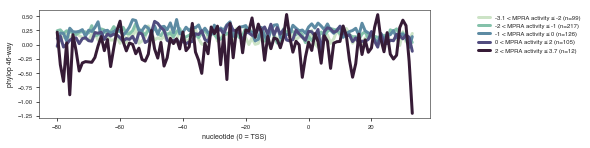

intergenic


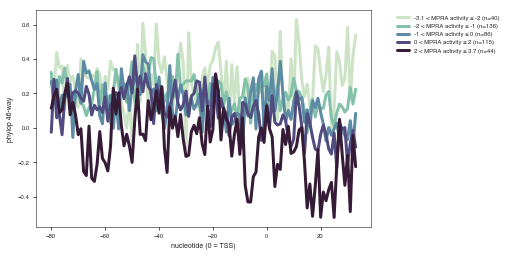

div_lnc


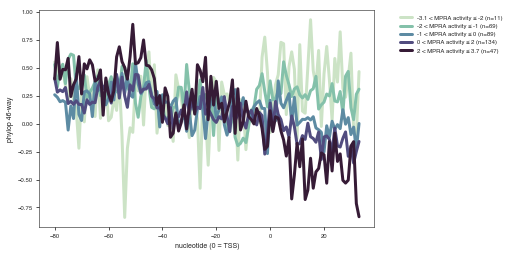

protein_coding


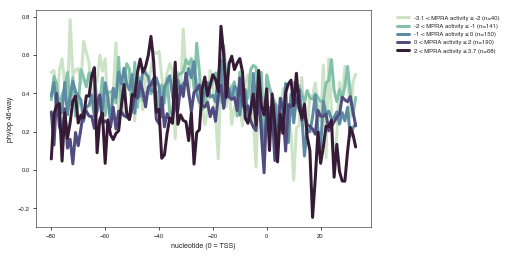

div_pc


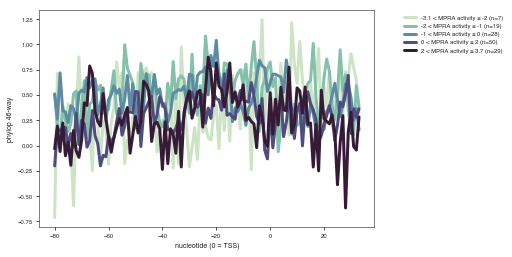

In [98]:
fig = plt.figure(figsize=(7,2))
palette = {-2: sns.cubehelix_palette(5, start=.75, rot=-.75)[0], -1: sns.cubehelix_palette(5, start=.75, rot=-.75)[1], 
           0: sns.cubehelix_palette(5, start=.75, rot=-.75)[2], 2: sns.cubehelix_palette(5, start=.75, rot=-.75)[3],
           4: sns.cubehelix_palette(5, start=.75, rot=-.75)[4]}
labels = ["-3.1 < MPRA activity ≤ -2", "-2 < MPRA activity ≤ -1", "-1 < MPRA activity ≤ 0", 
          "0 < MPRA activity ≤ 2", "2 < MPRA activity ≤ 3.7"]

for PromType2 in TSS_CLASS_ORDER:
    activ_res = res_dict[PromType2]
    print(PromType2)
    for n, label in zip(activ_res_dict.keys(), labels):
        res = activ_res[n]
        n_seqs = res["n_seqs"]
        avg = res["avg"]
        y1 = res["y1"]
        y2 = res["y2"]
        # x = signal.savgol_filter(df["mean"], 15, 1)
        # plt.fill_between(nuc_cols, y1, y2, color=palette[n], alpha=0.5)
        plt.plot(nuc_cols, avg, color=palette[n], linewidth=3, label="%s (n=%s)" % (label, n_seqs))
    # plt.xlim((lower, upper))
    # plt.axvline(x=-75, color="black", linestyle="dashed", linewidth=1)
    # plt.axvline(x=25, color="black", linestyle="dashed", linewidth=1)
    plt.legend(ncol=1, loc=1, bbox_to_anchor=(1.4, 1))
    plt.xlabel("nucleotide (0 = TSS)")
    plt.ylabel("phylop 46-way")
    plt.show()

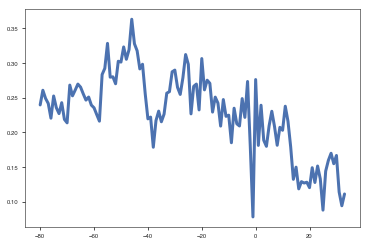

In [99]:
all_avg_nucs = all_activ_phylop[nuc_cols].mean(axis=0)
plt.plot(nuc_cols, all_avg_nucs, linewidth=3)

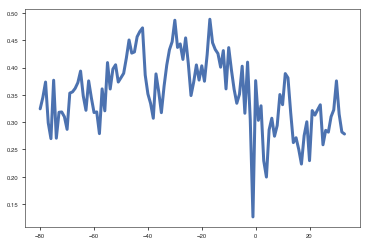

In [100]:
pc_avg_nucs = all_activ_phylop[all_activ_phylop["PromType2"] == "protein_coding"][nuc_cols].mean(axis=0)
plt.plot(nuc_cols, pc_avg_nucs, linewidth=3)

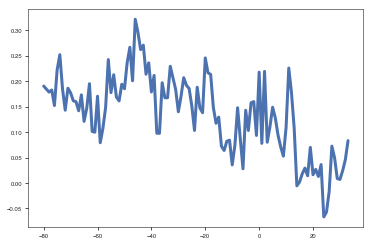

In [101]:
lnc_avg_nucs = all_activ_phylop[all_activ_phylop["PromType2"] == "intergenic"][nuc_cols].mean(axis=0)
plt.plot(nuc_cols, lnc_avg_nucs, linewidth=3)

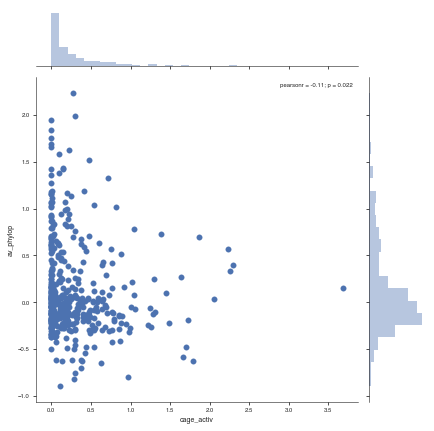

In [102]:
all_activ_phylop["av_phylop"] = all_activ_phylop[nuc_cols].mean(axis=1)
df = all_activ_phylop[all_activ_phylop["PromType2"] == "intergenic"]
sns.jointplot(data=df, x="cage_activ", y="av_phylop")

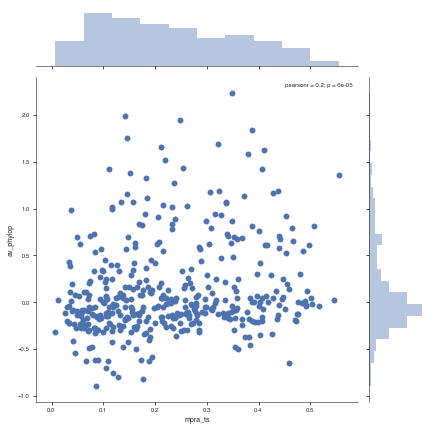

In [103]:
df = all_activ_phylop[all_activ_phylop["PromType2"] == "intergenic"]
sns.jointplot(data=df, x="mpra_ts", y="av_phylop")

In [104]:
df.sort_values(by="av_phylop", ascending=False).head()

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,25,26,27,28,29,30,31,32,33,av_phylop
1632,WILDTYPE__Lincrna.noflip.NA__chr21:17791642..1...,TGTTTAGTCTGGCGCACGGCTTCAGGGGAGATTGGCAGCTGGGTCA...,WILDTYPE,intergenic,-1.155699,-1.873965,-2.640661,not sig,not sig,not sig,...,2.30,1.55,1.57,0.14,1.51,1.11,2.85,-0.43,2.30,2.240439
979,WILDTYPE__Antisense.flip.sense__chr2:113993037...,CGGGACCCCGGAGCCGACTTGCTGCAGATCCAAAAAGGCGGAGCTA...,WILDTYPE,intergenic,1.904300,-0.081731,2.137644,not sig,sig active,sig active,...,2.54,0.85,0.86,0.62,2.54,1.25,0.85,1.26,2.05,1.990877
1555,WILDTYPE__Lincrna.noflip.NA__chr11:28724067..2...,AACTATTGTTTTCCTCTTCTGACTCATCTTTGAATCAGTAAATTAA...,WILDTYPE,intergenic,-1.695218,-2.045149,-1.343647,not sig,not sig,not sig,...,2.33,2.89,2.33,1.12,2.81,1.00,0.41,0.99,2.21,1.950175
1645,WILDTYPE__Lincrna.noflip.NA__chr2:105050738..1...,GGAGTCCAGGGTTTTTGTCACACACACACACAGCACAGATTTTTTT...,WILDTYPE,intergenic,-1.989735,-2.100721,-2.143888,not sig,not sig,not sig,...,2.86,1.55,0.51,1.04,2.86,2.86,2.31,2.31,2.31,1.840614
1752,WILDTYPE__Lincrna.noflip.NA__chr9:132083215..1...,GAAAAGATCAGTATCTGTCAGTCTGACAGCTGATTGGCTGCTCGGA...,WILDTYPE,intergenic,-0.004688,-1.799079,-0.034840,not sig,sig active,sig active,...,1.93,-0.43,1.15,1.93,2.38,1.09,1.93,0.77,1.88,1.760088


## 10. write final files

In [105]:
# write file with tissue-specificities for later use
final = all_activ[["unique_id", "PromType2", "cage_activ", "cage_ts", "mpra_activ", "mpra_ts"]]
final.to_csv("../../data/02__activs/POOL1__pMPRA1__CAGE_vs_MPRA_activs.txt", sep="\t", index=False)

In [106]:
# also write file with tss types
sel_map_expr.to_csv("../../misc/00__tss_properties/CAGE_expr_properties.txt", sep="\t", index=False)